## Initialization : Import Library

In [234]:
import pandas as pd
import glob
import re
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import os
import pickle as pkl
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data


## **Step 1 - Data Preprocessing**

### - **Extracting data from XML file one each sample**

In [118]:
data_annotation = pd.DataFrame(columns = ['Sample_id', 'Cns_subregion', 'Sample_group', 'Subject_id']) # initialisation of the dataframe
xtree = et.parse('./Data/GSE124439_family.xml') # create a variable containing the xml in a tree shape
xroot = xtree.getroot() # get the root of the tree to start the exploration of the tree/xml
# for each element named "sample" that can be found from the root
for child in xroot.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Sample"):
    temp_sample_id = child.attrib['iid'] # the attribut of this node contains the sample id ()
    # for each element named "Characteristics" that can be found from the current sample
    for child2 in child.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Characteristics"):
        if(child2.attrib["tag"] == "cns subregion"):  ##
            temp_cns_subregion = child2.text.replace('\n', '')
        if(child2.attrib["tag"] == "sample group"):
            temp_sample_group = child2.text.replace('\n', '')
        if(child2.attrib["tag"] == "subject id"):
            temp_subject_id = child2.text.replace('\n', '')
    temp_df = pd.DataFrame({'Sample_id': [temp_sample_id.strip()], 'Cns_subregion': [temp_cns_subregion.strip()], 'Sample_group': [temp_sample_group.strip()], 'Subject_id': [temp_subject_id.strip()]})
    data_annotation = pd.concat([data_annotation, temp_df])

In [119]:
data_annotation

,Sample_id,Cns_subregion,Sample_group,Subject_id
0,GSM3533230,Frontal Cortex,ALS Spectrum MND,NEUEL133AK6
0,GSM3533231,Frontal Cortex,ALS Spectrum MND,NEUYV496XLP
0,GSM3533232,Frontal Cortex,ALS Spectrum MND,NEUZU200WEQ
0,GSM3533233,Frontal Cortex,ALS Spectrum MND,NEUME287RK2
0,GSM3533234,Frontal Cortex,ALS Spectrum MND,NEUEC006FND
...,...,...,...,...
0,GSM3533401,Frontal Cortex,ALS Spectrum MND,NEUMY028JH4
0,GSM3533402,Frontal Cortex,ALS Spectrum MND,NEUXR145UBL
0,GSM3533403,Frontal Cortex,ALS Spectrum MND,NEUKN209FNW
0,GSM3533404,Frontal Cortex,ALS Spectrum MND,NEUUF289NRL


In [120]:
data_annotation['Cns_subregion'].unique() ## selection to see the different types of regions

array(['Frontal Cortex', 'Motor Cortex (Medial)',
       'Motor Cortex (Lateral)', 'Motor Cortex'], dtype=object)

*There are 4 regions represented in our samples, all parts of the brain.*

In [121]:
data_annotation['Sample_group'].unique() ## selection to see the different types of subject

array(['ALS Spectrum MND', 'Non-Neurological Control',
       'Other Neurological Disorders'], dtype=object)

*3 types of patients in our data :* 
- **Patient with ALS**
- **Patient without ALS but have other neurological disorder**
- **Patient without any neurological disorder**

In [122]:
## Number of subject, Number of samples
print("Number of patients :",len(data_annotation['Subject_id'].unique()),"\nNumber of samples :", len(data_annotation['Sample_id'].unique()))

Number of patients : 95 
Number of samples : 176


*There is 95 different patients (some sample may originate from the same patient)*

### - **Retrieving all the data from RNA-seq**

In [123]:
path = "./Data" # the path of the data

pdList = [] # variable to temporary store all dataframes (one for each txt file)
# For all txt file
for fname in glob.glob(path+"/*.txt"):
    df = pd.read_table(fname) # put the file in a dataframe
    sample_name = re.search("GSM\d+", fname).group() # search the name of the sample in the file name
    df.rename(index= df["gene/TE"], inplace=True) # rename the index (=rows) using the column containing the gene name
    df.drop(columns=df.columns[0], axis=1, inplace=True) # drop the first column containing the gene name, no more need
    df.rename(columns={ df.columns[0]: sample_name }, inplace = True) # rename the column (there is only one column at this step) using the sample name
    pdList.append(df) # add the current dataframe in the list

In [124]:
data_matrix = pd.concat(pdList, axis=1) # concat all dataframe in 1 dataframe
data_matrix

,GSM3533314,GSM3533339,GSM3533344,GSM3533277,GSM3533269,GSM3533279,GSM3533232,GSM3533338,GSM3533375,GSM3533272,...,GSM3533308,GSM3533297,GSM3533244,GSM3533389,GSM3533388,GSM3533235,GSM3533285,GSM3533392,GSM3533390,GSM3533399
A1BG,14,39,17,37,44,38,20,28,26,74,...,48,20,14,20,23,15,37,42,30,46
A1BG-AS1,41,95,43,95,105,83,95,100,84,161,...,65,114,113,114,147,39,136,175,85,179
A1CF,0,0,4,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,2185,1223,900,2847,2222,2391,1830,1025,1768,3094,...,1567,1663,1836,920,1271,957,2595,2684,1670,2899
A2M-AS1,105,74,73,98,63,121,121,78,79,112,...,89,88,122,75,61,74,88,83,78,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X8_LINE:CR1:LINE,527,354,350,545,246,555,571,299,514,543,...,334,484,465,371,441,267,717,441,410,469
X9_LINE:L1:LINE,145,83,99,117,52,106,126,108,125,146,...,73,110,149,74,107,65,183,123,106,99
Zaphod2:hAT-Tip100:DNA,446,300,351,377,242,522,479,274,472,390,...,266,484,523,303,454,256,605,372,318,442
Zaphod3:hAT-Tip100:DNA,1522,1145,1256,1569,948,2087,1659,1081,1797,1806,...,1056,1620,1862,1141,1640,866,2275,1310,1286,1684


In [125]:
# transpose the dataframe to get a more standard shape with sample as entry and gene as columns
data_matrix = data_matrix.transpose() 
data_matrix

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533314,14,41,0,2185,105,198,4,0,24,0,...,958,2017,1817,1087,99,527,145,446,1522,1757
GSM3533339,39,95,0,1223,74,89,1,3,39,0,...,687,1424,1340,693,101,354,83,300,1145,1390
GSM3533344,17,43,4,900,73,113,1,2,6,1,...,727,1561,1372,702,83,350,99,351,1256,1479
GSM3533277,37,95,0,2847,98,164,8,6,22,0,...,873,1785,1823,887,112,545,117,377,1569,1769
GSM3533269,44,105,1,2222,63,74,9,2,17,0,...,482,1060,1073,532,69,246,52,242,948,1125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533235,15,39,0,957,74,48,1,2,21,0,...,446,1066,1022,635,63,267,65,256,866,977
GSM3533285,37,136,0,2595,88,162,0,1,26,0,...,1032,2523,2216,1399,131,717,183,605,2275,2280
GSM3533392,42,175,0,2684,83,105,2,3,15,0,...,705,1548,1299,733,61,441,123,372,1310,1437
GSM3533390,30,85,0,1670,78,245,3,0,34,0,...,712,1641,1515,868,70,410,106,318,1286,1436


In [126]:
# A list with all possible genes in our data
list_all_genes = list(data_matrix.columns.values) 
print("Number of genes :",len(list_all_genes))

Number of genes : 28953


### - **Merging in a unique dataframe all the information**

In [127]:
data_frame_merged = data_annotation.merge(data_matrix, right_index=True, left_on="Sample_id")

In [128]:
data_frame_merged

,Sample_id,Cns_subregion,Sample_group,Subject_id,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
0,GSM3533230,Frontal Cortex,ALS Spectrum MND,NEUEL133AK6,42,149,0,3327,101,78,...,986,2218,2096,1120,84,556,134,570,2045,2446
0,GSM3533231,Frontal Cortex,ALS Spectrum MND,NEUYV496XLP,25,107,2,1787,153,109,...,1216,2373,2001,1144,118,582,153,552,2057,2279
0,GSM3533232,Frontal Cortex,ALS Spectrum MND,NEUZU200WEQ,20,95,0,1830,121,127,...,905,2018,1815,1011,84,571,126,479,1659,1778
0,GSM3533233,Frontal Cortex,ALS Spectrum MND,NEUME287RK2,22,101,0,2131,142,143,...,935,2278,2032,1198,97,562,132,540,2032,2135
0,GSM3533234,Frontal Cortex,ALS Spectrum MND,NEUEC006FND,22,102,0,1706,83,178,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,GSM3533401,Frontal Cortex,ALS Spectrum MND,NEUMY028JH4,23,113,0,2130,72,71,...,553,1243,1089,658,72,320,73,311,1102,1169
0,GSM3533402,Frontal Cortex,ALS Spectrum MND,NEUXR145UBL,134,300,0,6077,171,42,...,719,1988,1691,966,119,460,109,399,1619,1724
0,GSM3533403,Frontal Cortex,ALS Spectrum MND,NEUKN209FNW,64,290,0,4752,118,174,...,623,1466,1246,726,61,358,107,347,1284,1469
0,GSM3533404,Frontal Cortex,ALS Spectrum MND,NEUUF289NRL,124,332,0,3516,141,173,...,743,1846,1680,936,110,479,120,503,1646,1839


In [129]:
# we set Sample_id as the index of this dataframe
data_frame_merged = data_frame_merged.set_index('Sample_id')
data_frame_merged

,Cns_subregion,Sample_group,Subject_id,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533230,Frontal Cortex,ALS Spectrum MND,NEUEL133AK6,42,149,0,3327,101,78,4,...,986,2218,2096,1120,84,556,134,570,2045,2446
GSM3533231,Frontal Cortex,ALS Spectrum MND,NEUYV496XLP,25,107,2,1787,153,109,2,...,1216,2373,2001,1144,118,582,153,552,2057,2279
GSM3533232,Frontal Cortex,ALS Spectrum MND,NEUZU200WEQ,20,95,0,1830,121,127,1,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533233,Frontal Cortex,ALS Spectrum MND,NEUME287RK2,22,101,0,2131,142,143,5,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533234,Frontal Cortex,ALS Spectrum MND,NEUEC006FND,22,102,0,1706,83,178,1,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,Frontal Cortex,ALS Spectrum MND,NEUMY028JH4,23,113,0,2130,72,71,2,...,553,1243,1089,658,72,320,73,311,1102,1169
GSM3533402,Frontal Cortex,ALS Spectrum MND,NEUXR145UBL,134,300,0,6077,171,42,8,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533403,Frontal Cortex,ALS Spectrum MND,NEUKN209FNW,64,290,0,4752,118,174,8,...,623,1466,1246,726,61,358,107,347,1284,1469


### **Median Ratio Normalization (MRN) :**
*The MRN method is based on the assumption that the majority of genes are not differentially expressed between samples. It corrects for technical biases such as* \
*differences in sequencing depth across samples. This method makes the counts comparable between samples while preserving true biological variation in gene expression.*
1. Let $K_{ij}$ be the raw count of gene $i$ in sample $j$, with $m$ samples and $n$ genes in total.

2. Compute the **geometric mean** of the counts for each gene $i$ across all samples:

   $$
   G_i = \exp \left( \frac{1}{m} \sum_{j=1}^{m} \ln(K_{ij}) \right)
   $$
    *Note: To avoid problems with $\log(0)$, a pseudocount (e.g., $K_{ij} + 1$) is added.*

3. Compute the **ratios** of each gene's count in a sample to its geometric mean:

   $$
   R_{ij} = \frac{K_{ij}}{G_i}
   $$

4. The **normalization factor** $s_j$ for sample $j$ is the median of all ratios $R_{ij}$ for that sample:

   $$
   s_j = \text{median}_i \left( \frac{K_{ij}}{G_i} \right)
   $$

5. The **normalized counts** are obtained by dividing each raw count by its sample's normalization factor:

   $$
   K_{ij}^{(\text{norm})} = \frac{K_{ij}}{s_j}
   $$

In [130]:
class als_rnaseq:
    """ Class containing the data and some methods to select specific entries or columns"""
    def __init__(self):
        self.__data_matrix = data_frame_merged # we set the merged dataframe as the default data
        self.__list_genes = list_all_genes # we give the list of all genes for future use

    def get_data_matrix(self): # get the merged dataframe with all informations
        return self.__data_matrix
    
    def get_data_genes(self) : # get only the RNA-seq information from each sample (i.e filters all information from XML)
        return self.get_data_matrix()[self.__list_genes]
    
    def get_data_subregion_genes(self) : # get in addition of genes count, the subregion of origin
        list_features = ['Cns_subregion'] ## get the subregion column
        list_features.extend(self.__list_genes) ## add all the genes
        return self.get_data_matrix()[list_features] ## filter everything out outside of subregion and genes
    
    def get_mrn_data_genes(self) : # apply the Median Ratio Normalization
        geometric_mean = np.exp(np.mean(np.log(self.get_data_genes() + 1), axis=1)) ## get the geometric mean (cf. step 2)
        ratios = self.get_data_genes().div(geometric_mean, axis=0) ## get the ratios (cf. step 3)
        normalization_factors = ratios.median(axis=0) ## get the normlization factors (cf. step 4)
        normalized_data = self.get_data_genes().div(normalization_factors, axis=1) ## get the final normalization on the data (cf. step 5)
        normalized_data = normalized_data.fillna(0) ## fill NaN values from previous calculations with 0
        normalized_data = normalized_data.replace([np.inf, -np.inf], 0) ## fill inf values from previous calculations with 0
        return normalized_data
    
    def get_data_als(self, normalized=True) :
        df = self.get_data_matrix() ## get the whole dataframe
        df_als = df[ df['Sample_group'] == 'ALS Spectrum MND'] ## filter out only ALS sample
        if not normalized: ## if we don't want normalized data
            return df_als[self.__list_genes]
        else : ## if we want normalized data
            df_normalized = self.get_mrn_data_genes() ## get normalized data
            df_normalized = df_normalized.loc[df_als.index] ## filter out only ALS normalized data
            return df_normalized

    def get_data_control(self, normalized=True) :
        df = self.get_data_matrix() ## get the whole dataframe
        df_als = df[ df['Sample_group'] != 'ALS Spectrum MND'] ## filter out only non ALS sample
        if not normalized: ## if we don't want normalized data
            return df_als[self.__list_genes]
        else : ## if we want normalized data
            df_normalized = self.get_mrn_data_genes() ## get normalized data
            df_normalized = df_normalized.loc[df_als.index] ## filter out only non ALS normalized data
            return df_normalized

    def __str__(self):
        return "Data Frame of RNA seq samples"

In [131]:
data_instance = als_rnaseq()  ## create an instance of our class for global use

In [132]:
data_instance.get_data_als() ## check the normalized als data 

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533230,62.142795,64.963009,0.0,74.308365,51.167678,31.418698,89.142205,0.000000,92.834541,0.0,...,59.272313,62.552192,62.885055,62.301173,45.360002,59.051866,60.100423,69.710306,62.926565,69.440780
GSM3533231,36.989759,46.651288,0.0,39.912548,77.511433,43.905617,44.571103,23.397455,34.639754,0.0,...,73.098511,66.923513,60.034826,63.636199,63.720003,61.813285,68.622125,67.508928,63.295817,64.699729
GSM3533232,29.591807,41.419368,0.0,40.872951,61.299891,51.156086,22.285551,23.397455,15.241492,0.0,...,54.403086,56.911778,54.454378,56.237934,45.360002,60.644992,56.512338,58.581117,51.048984,50.476577
GSM3533233,32.550988,44.035328,0.0,47.595769,71.938715,57.600947,111.427756,23.397455,49.881246,0.0,...,56.206503,64.244316,60.964901,66.640005,52.380003,59.689117,59.203402,66.041342,62.526543,60.611637
GSM3533234,32.550988,44.471321,0.0,38.103417,42.048686,71.699081,22.285551,70.192364,42.953295,0.0,...,58.070035,64.723751,59.794807,64.081207,51.840003,61.813285,55.615317,65.919044,53.602972,55.047290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,34.030578,49.267248,0.0,47.573434,36.475968,28.599071,44.571103,70.192364,29.097394,0.0,...,33.242991,35.055173,32.672627,36.601939,38.880002,33.986686,32.741275,38.034921,33.909572,33.187356
GSM3533402,198.265108,130.798004,0.0,135.729465,86.630425,16.917761,178.284410,116.987274,311.757788,0.0,...,43.221899,56.065716,50.734078,53.734762,64.260003,48.855861,48.887657,48.797214,49.818146,48.943542
GSM3533403,94.693783,126.438071,0.0,106.135662,59.780059,70.087865,178.284410,46.794910,187.054673,0.0,...,37.450964,41.344235,37.383005,40.384511,32.940002,38.022605,47.990636,42.437677,39.509883,41.704213


In [133]:
data_instance.get_data_control() ## check the normalized control data 

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533238,50.306072,36.623441,0.0,15.120758,22.797480,38.266363,22.285551,23.397455,102.533672,0.0,...,39.134154,37.142127,35.642865,38.215095,34.020002,33.243227,24.219573,39.257909,40.925346,43.861817
GSM3533251,161.275349,67.142976,0.0,57.177461,68.899051,47.128047,89.142205,93.589819,88.677771,0.0,...,33.483446,40.526375,38.523097,46.392124,43.200002,33.880477,39.468934,38.524116,31.755607,33.045408
GSM3533259,93.214192,55.807149,0.0,44.312532,38.502411,30.613091,44.571103,23.397455,87.292181,0.0,...,37.450964,45.095110,43.443492,46.614628,30.780001,44.182691,34.983828,48.308019,47.141075,45.536799
GSM3533266,54.744843,54.063175,0.0,54.765287,37.995800,49.142066,66.856654,116.987274,27.711803,0.0,...,53.140694,55.163249,54.874411,53.067250,48.600002,52.360738,54.269785,52.710775,50.618191,56.551935
GSM3533272,109.489686,70.194929,0.0,69.104322,56.740395,62.031789,178.284410,93.589819,24.940623,0.0,...,53.441264,54.994037,61.444939,54.457901,67.500003,57.671157,65.482550,47.696525,55.572312,56.126092
GSM3533277,54.744843,41.419368,0.0,63.587591,49.647846,66.059827,178.284410,140.384729,30.482984,0.0,...,52.479441,50.340695,54.694397,49.340304,60.480003,57.883574,52.475742,46.106641,48.279600,50.221071
GSM3533282,48.826482,61.039069,0.0,66.513468,60.286670,53.170105,0.000000,140.384729,76.207459,0.0,...,56.507073,58.575700,59.584790,57.684212,55.080003,55.971823,64.585529,56.135141,58.772489,58.624370
GSM3533290,23.673446,46.651288,0.0,89.205773,44.581739,74.921511,44.571103,46.794910,58.194787,0.0,...,45.506228,49.381825,43.323483,47.782775,39.960002,42.801982,45.299572,48.308019,44.187065,45.593578
GSM3533298,54.744843,40.547381,0.0,55.278991,69.405662,70.087865,111.427756,23.397455,24.940623,0.0,...,49.353518,51.807203,54.844409,52.399737,45.900002,47.687568,49.336168,48.430318,49.110415,46.473654


## **Step 2 - Descriptive Analysis**

### **- Stats regarding samples**

In [134]:
data_by_disease_grp = data_instance.get_data_matrix()['Sample_group'].value_counts() ## get the count of each value in a column 
print("Number of sample in each", data_by_disease_grp)

Number of sample in each Sample_group
ALS Spectrum MND                145
Non-Neurological Control         17
Other Neurological Disorders     14
Name: count, dtype: int64


In [135]:
print("Basic stats of the data according to the diseases group: ")
data_by_disease_grp.describe() ## get the basic stats from a dataframe

Basic stats of the data according to the diseases group: 


count      3.000000
mean      58.666667
std       74.781905
min       14.000000
25%       15.500000
50%       17.000000
75%       81.000000
max      145.000000
Name: count, dtype: float64

In [136]:
data_by_genes_mean = data_instance.get_data_genes().mean() ## calculate the mean of every column in a dataframe
print("The mean value count for each gene: ")
data_by_genes_mean

The mean value count for each gene: 


A1BG                        38.062500
A1BG-AS1                   118.568182
A1CF                         0.170455
A2M                       2455.403409
A2M-AS1                    102.568182
                             ...     
X8_LINE:CR1:LINE           462.647727
X9_LINE:L1:LINE            110.863636
Zaphod2:hAT-Tip100:DNA     415.931818
Zaphod3:hAT-Tip100:DNA    1555.630682
Zaphod:hAT-Tip100:DNA     1735.556818
Length: 28953, dtype: float64

In [137]:
print("Basic stats of the data according to the genes mean (stats on the genes mean, not raw count): ")
data_by_genes_mean.describe() ## get the basic stats from a dataframe

Basic stats of the data according to the genes mean (stats on the genes mean, not raw count): 


count     28953.000000
mean        888.421839
std        5513.503025
min           0.000000
25%           2.051136
50%          78.028409
75%         591.352273
max      366426.198864
dtype: float64

In [138]:
data_by_subregion = data_instance.get_data_matrix()['Cns_subregion'].value_counts() ## get the count of each value in a column 
print("Number of sample in each", data_by_disease_grp)
print("Number of sample in each", data_by_subregion)

Number of sample in each Sample_group
ALS Spectrum MND                145
Non-Neurological Control         17
Other Neurological Disorders     14
Name: count, dtype: int64
Number of sample in each Cns_subregion
Frontal Cortex            81
Motor Cortex (Medial)     45
Motor Cortex (Lateral)    45
Motor Cortex               5
Name: count, dtype: int64


In [139]:
print("Basic stats of the data according to the sub-region: ")
data_by_subregion.describe() ## get the basic stats from a dataframe

Basic stats of the data according to the sub-region: 


count     4.000000
mean     44.000000
std      31.048349
min       5.000000
25%      35.000000
50%      45.000000
75%      54.000000
max      81.000000
Name: count, dtype: float64

In [140]:
data_by_subjectid = data_instance.get_data_matrix()['Subject_id'].value_counts() ## get the count of each value in a column 
print("Number of sample in each", data_by_subjectid)

Number of sample in each Subject_id
NEURX991BWB    3
JHU 73         3
JHU 74         3
JHU 83         3
NEUHC282LVJ    3
              ..
NEUMY028JH4    1
NEUXR145UBL    1
NEUKN209FNW    1
NEUUF289NRL    1
NEUPU334DL1    1
Name: count, Length: 95, dtype: int64


In [141]:
print("Basic stats of the data according to the subject: ")
data_by_subjectid.describe() ## get the basic stats from a dataframe

Basic stats of the data according to the subject: 


count    95.000000
mean      1.852632
std       0.898799
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       3.000000
Name: count, dtype: float64

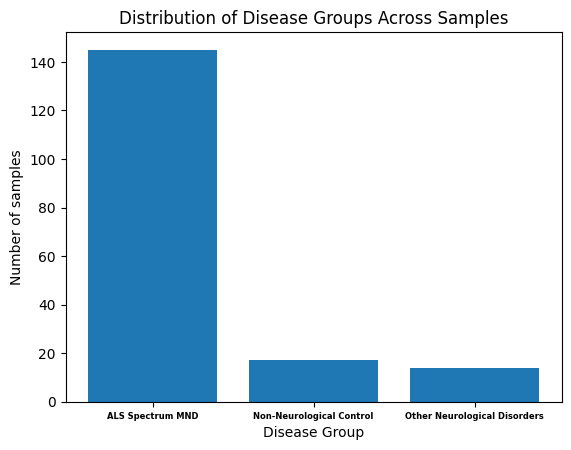

In [142]:
# Bar charts for Disease Group
plt.bar(data_by_disease_grp.index, data_by_disease_grp.values)

# Add titles and labels
plt.title('Distribution of Disease Groups Across Samples')
plt.xlabel('Disease Group')
plt.ylabel('Number of samples')

# Change x labels fonts
plt.xticks(fontweight='bold', fontsize=6)

# Show the chart
plt.show()

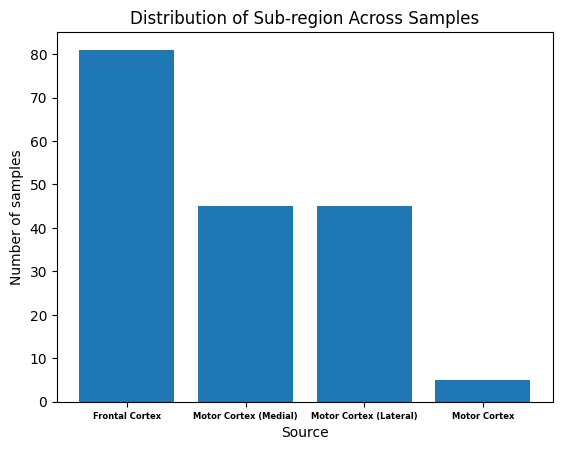

In [143]:
# Bar charts for Sub-region
plt.bar(data_instance.get_data_matrix()['Cns_subregion'].unique(), data_instance.get_data_matrix()['Cns_subregion'].value_counts())

# Add titles and labels
plt.title('Distribution of Sub-region Across Samples')
plt.xlabel('Source')
plt.ylabel('Number of samples')

# Change x labels fonts
plt.xticks(fontweight='bold', fontsize=6)

# Show the chart
plt.show()

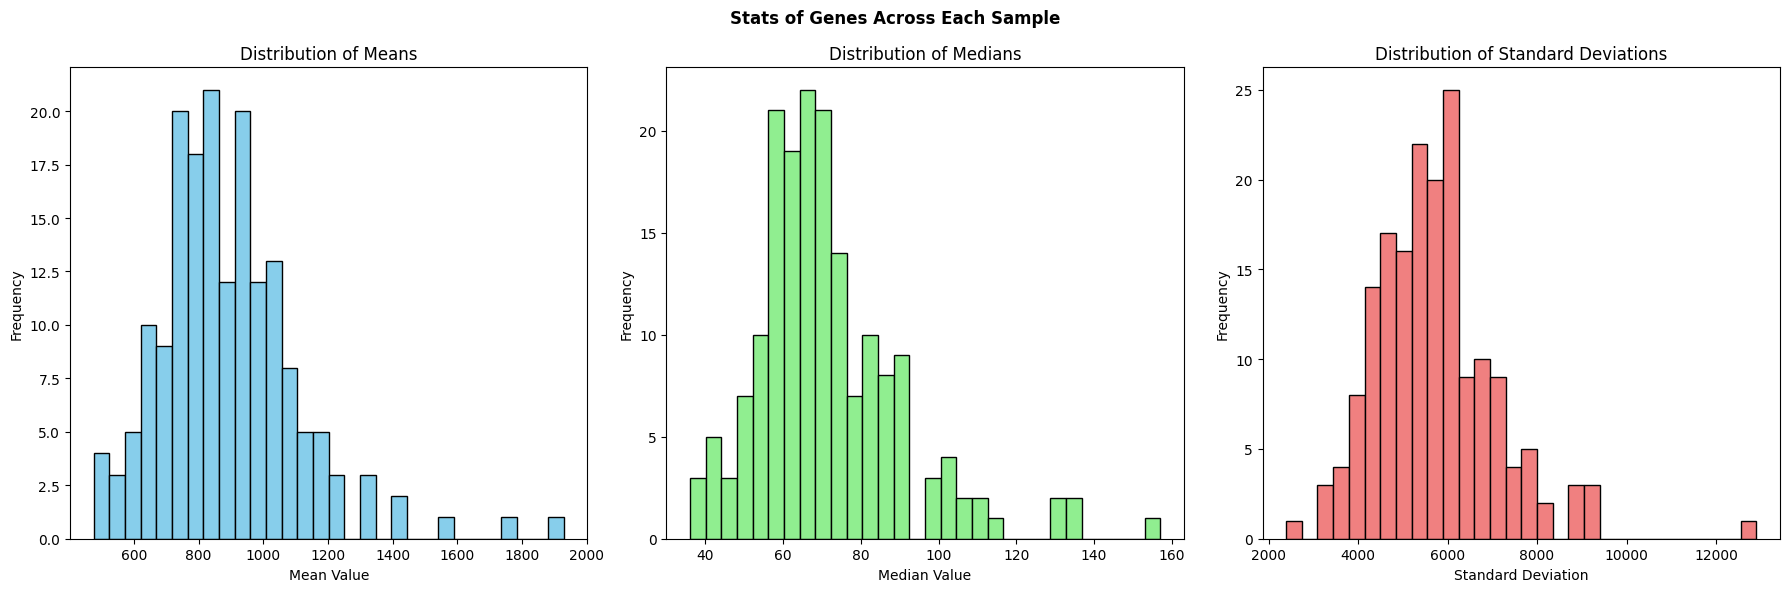

In [144]:
# Histogramms for genes stats
data_for_plots = data_instance.get_data_genes()


means = np.mean(data_for_plots.values, axis=1)
medians = np.median(data_for_plots.values, axis=1)
std_devs = np.std(data_for_plots.values, axis=1)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Histo means
axs[0].hist(means, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Means')
axs[0].set_xlabel('Mean Value')
axs[0].set_ylabel('Frequency')

# Histo for medians
axs[1].hist(medians, bins=30, color='lightgreen', edgecolor='black')
axs[1].set_title('Distribution of Medians')
axs[1].set_xlabel('Median Value')
axs[1].set_ylabel('Frequency')

# Histo for std deviation
axs[2].hist(std_devs, bins=30, color='lightcoral', edgecolor='black')
axs[2].set_title('Distribution of Standard Deviations')
axs[2].set_xlabel('Standard Deviation')
axs[2].set_ylabel('Frequency')

# Overall title of plot
plt.suptitle('Stats of Genes Across Each Sample', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [145]:
means = data_instance.get_data_genes().mean(axis=1) # calculate the mean of every columns in the dataframe
medians = data_instance.get_data_genes().median(axis=1) # calculate the median of every columns in the dataframe
std_devs = data_instance.get_data_genes().std(axis=1) # calculate the standard deviation of every columns in the dataframe

sample_ids = data_instance.get_data_genes().index # get every samples id by getting the index of the dataframe

data = { ## create the dictionnary containing all previously calculated stats for every samples
    'Mean': means,
    'Median':medians,
    'Std_dev': std_devs,
}

sample_stats = pd.DataFrame(data) ## convert the previous dictionnary to a dataframe for better use

print("Dataframe of Samples stats :")
sample_stats

Dataframe of Samples stats :


,Mean,Median,Std_dev
Sample_id,,,
GSM3533230,1041.382378,92.0,7144.948717
GSM3533231,881.608503,65.0,6556.784539
GSM3533232,802.592132,58.0,5618.694081
GSM3533233,785.868615,65.0,6617.736421
GSM3533234,906.813525,61.0,6815.130467
...,...,...,...
GSM3533401,621.179187,51.0,3875.932581
GSM3533402,1412.596518,136.0,7679.231478
GSM3533403,1142.241288,101.0,5264.705168


#### **Study on an outlier**

In [146]:
sample_stats[sample_stats['Std_dev']==max(sample_stats['Std_dev'].values)] ## We retrieve the max outliers of std values

,Mean,Median,Std_dev
Sample_id,,,
GSM3533364,1929.230132,157.0,12904.004636


In [147]:
data_instance.get_data_matrix().loc['GSM3533364'] ## Describe the outliers data

Cns_subregion             Motor Cortex (Medial)
Sample_group                   ALS Spectrum MND
Subject_id                               JHU 83
A1BG                                         58
A1BG-AS1                                    228
                                  ...          
X8_LINE:CR1:LINE                           1180
X9_LINE:L1:LINE                             255
Zaphod2:hAT-Tip100:DNA                      954
Zaphod3:hAT-Tip100:DNA                     3946
Zaphod:hAT-Tip100:DNA                      3902
Name: GSM3533364, Length: 28956, dtype: object

In [148]:
print("The genes with the highest count from the outlier :", data_instance.get_data_genes().loc['GSM3533364'].idxmax(), "; the count :",data_instance.get_data_genes().loc['GSM3533364'].max())
print("The std of the gene with the highest count:", data_instance.get_data_genes()['MIRb:MIR:SINE'].std(),"\nThe Mean of the gene with the highest count:", data_instance.get_data_genes()['MIRb:MIR:SINE'].mean())
print("The patient of origin of the outlier :", data_instance.get_data_matrix().loc['GSM3533364']['Subject_id'])

The genes with the highest count from the outlier : MIRb:MIR:SINE ; the count : 884080
The std of the gene with the highest count: 100627.5532686476 
The Mean of the gene with the highest count: 366426.19886363635
The patient of origin of the outlier : JHU 83


In [149]:
## Enumerating every sample of the patient
data_instance.get_data_matrix()[data_instance.get_data_matrix()['Subject_id']=="JHU 83"]

,Cns_subregion,Sample_group,Subject_id,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533363,Motor Cortex (Lateral),ALS Spectrum MND,JHU 83,19,125,0,2264,85,93,1,...,635,1534,1372,733,98,407,88,396,1369,1486
GSM3533364,Motor Cortex (Medial),ALS Spectrum MND,JHU 83,58,228,0,3953,227,260,4,...,1824,4240,3761,2046,235,1180,255,954,3946,3902
GSM3533365,Motor Cortex (Lateral),ALS Spectrum MND,JHU 83,32,91,0,2537,87,84,2,...,637,1505,1384,724,90,358,65,348,1408,1409


In [150]:
## Stats of all samples from the patient
outlier_ids = data_instance.get_data_matrix()[data_instance.get_data_matrix()['Subject_id']=="JHU 83"].index.values.tolist()
for id in outlier_ids:
    print("id sample:",id,"; mean:",data_instance.get_data_genes().loc[id].mean(), "; median:",data_instance.get_data_genes().loc[id].median(), "; std:",data_instance.get_data_genes().loc[id].std())

id sample: GSM3533363 ; mean: 736.4009601768383 ; median: 60.0 ; std: 4855.3268535997095
id sample: GSM3533364 ; mean: 1929.230131592581 ; median: 157.0 ; std: 12904.004635996334
id sample: GSM3533365 ; mean: 754.6600006907747 ; median: 65.0 ; std: 4815.672408576015


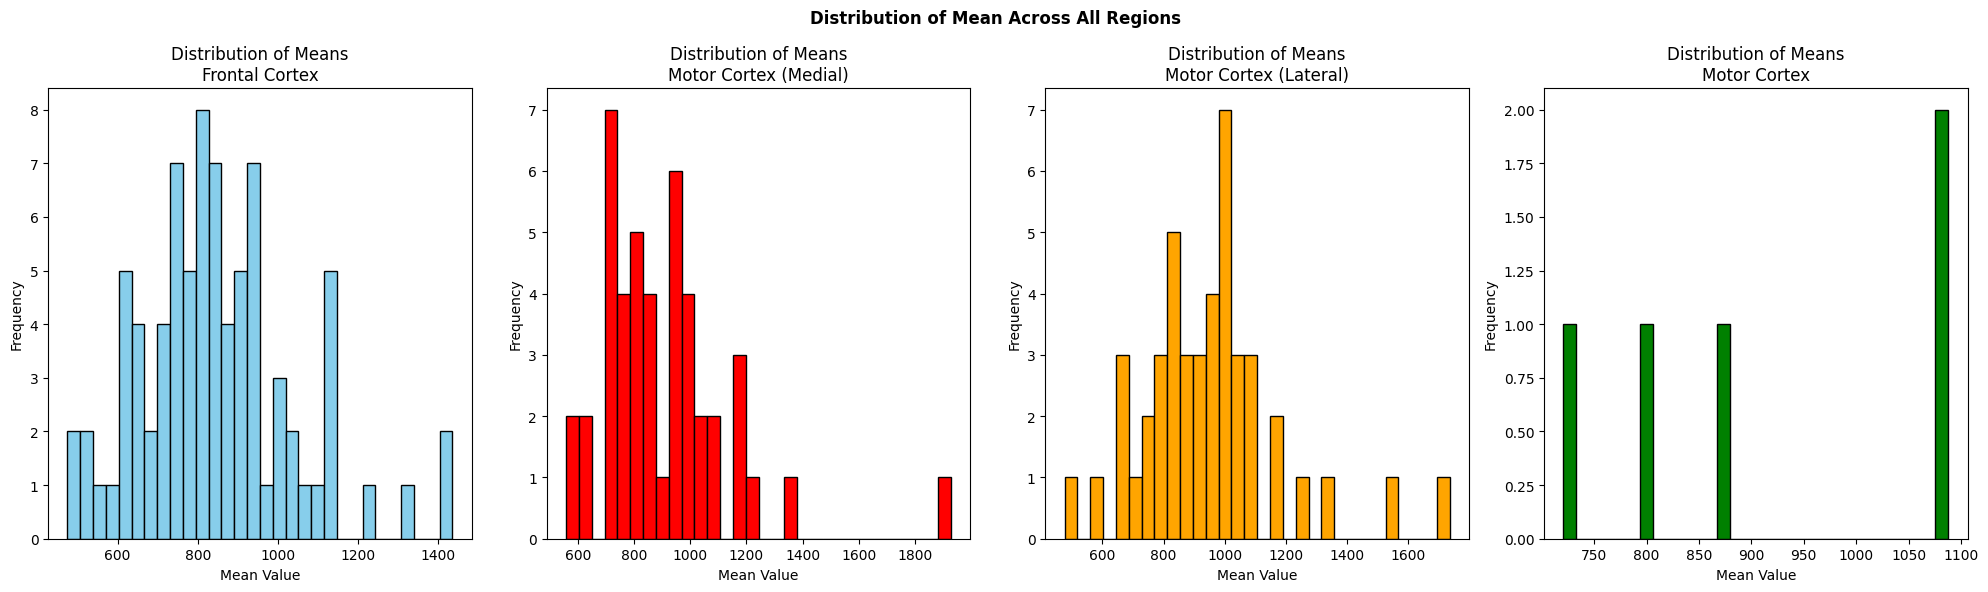

In [151]:
# Histograms of means across all sub regions
fig, axs = plt.subplots(1, 4, figsize=(20, 6)) 

unique_regions = data_instance.get_data_subregion_genes()['Cns_subregion'].unique()

data_for_distribution = data_instance.get_data_subregion_genes()

color = ['skyblue', 'red', 'orange', 'green']

for i, region in enumerate(unique_regions):
    sub_region_data = data_for_distribution[data_for_distribution['Cns_subregion'] == unique_regions[i]]
    row_means = sub_region_data.mean(axis=1, numeric_only=True)
    axs[i].hist(row_means, bins=30, color=color[i], edgecolor='black')
    axs[i].set_title(f'Distribution of Means\n{region}')
    axs[i].set_xlabel('Mean Value')
    axs[i].set_ylabel('Frequency')

# Overall title of plot
plt.suptitle('Distribution of Mean Across All Regions', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [152]:
data_for_mean_study = data_instance.get_data_subregion_genes()
numerical_columns = data_for_mean_study.select_dtypes(include=['number']) ## get every column that are numerical value
data_for_mean_study.loc[:, 'mean'] = numerical_columns.mean(axis=1) ## add a new column mean that is the mean of each sample count across all genes
data_for_mean_study

/tmp/ipykernel_1563/2824228300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_mean_study.loc[:, 'mean'] = numerical_columns.mean(axis=1) ## add a new column mean that is the mean of each sample count across all genes


,Cns_subregion,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,...,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,mean
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533230,Frontal Cortex,42,149,0,3327,101,78,4,0,67,...,2218,2096,1120,84,556,134,570,2045,2446,1041.382378
GSM3533231,Frontal Cortex,25,107,2,1787,153,109,2,1,25,...,2373,2001,1144,118,582,153,552,2057,2279,881.608503
GSM3533232,Frontal Cortex,20,95,0,1830,121,127,1,1,11,...,2018,1815,1011,84,571,126,479,1659,1778,802.592132
GSM3533233,Frontal Cortex,22,101,0,2131,142,143,5,1,36,...,2278,2032,1198,97,562,132,540,2032,2135,785.868615
GSM3533234,Frontal Cortex,22,102,0,1706,83,178,1,3,31,...,2295,1993,1152,96,582,124,539,1742,1939,906.813525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,Frontal Cortex,23,113,0,2130,72,71,2,3,21,...,1243,1089,658,72,320,73,311,1102,1169,621.179187
GSM3533402,Frontal Cortex,134,300,0,6077,171,42,8,5,225,...,1988,1691,966,119,460,109,399,1619,1724,1412.596518
GSM3533403,Frontal Cortex,64,290,0,4752,118,174,8,2,135,...,1466,1246,726,61,358,107,347,1284,1469,1142.241288


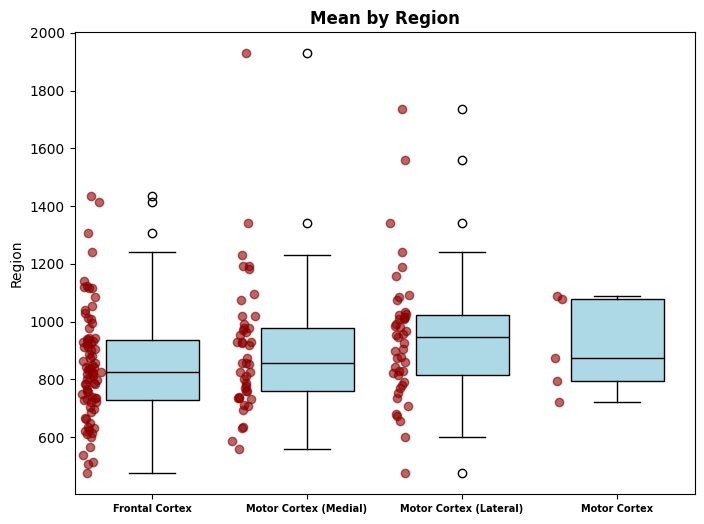

In [153]:
fig, ax = plt.subplots(figsize=(8,6))

## extract data for each region
groups = [data_for_mean_study[data_for_mean_study['Cns_subregion'] == region]['mean'] for region in data_for_mean_study['Cns_subregion'].unique()]

box = ax.boxplot(groups, patch_artist=True, widths=0.6,
                 boxprops=dict(facecolor='lightblue', color='black'),
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='black'),
                 capprops=dict(color='black'))

for i, group in enumerate(groups, 1):
    x = np.random.normal(i - 0.4, 0.03, size=len(group)) 
    ax.scatter(x, group, color='darkred', alpha=0.6)

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(data_for_mean_study['Cns_subregion'].unique())
ax.set_ylabel('Region')
ax.set_title('Mean by Region', fontweight="bold")
plt.xticks(fontweight='bold', fontsize=7)

plt.show()

In [154]:
def find_outliers(df, column, groupby_col=None): ## calculate the outliers from a dataframe given a statistical column
    if groupby_col!=None: ## if its a categorical study on multiple value, get the outliers for each categorical value
        outliers = [] ## list of the outliers to return
        for region, group in df.groupby(groupby_col): ## iter on in categorical value
            Q1 = group[column].quantile(0.25) # calculate the first quartile of the column in the group
            Q3 = group[column].quantile(0.75) # calculate the third quartile of the column in the group
            IQR = Q3 - Q1 # compute the interquartile range to measures the spread of the middle 50% of the data
            lower_bound = Q1 - 1.5 * IQR # define the lower bound for outlier detection (1.5 times the IQR below Q1)
            upper_bound = Q3 + 1.5 * IQR # define the upper bound for outlier detection (1.5 times the IQR above Q3)
            
            # Find outliers according the previous bounds
            outlier_values = group[(group[column] < lower_bound) | (group[column] > upper_bound)]
            outliers.append(outlier_values)
        
        return pd.concat(outliers)
    else: ## if there is only 1 category or no category, get the outliers from the whole dataframe
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers for the entire dataset
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        return outliers

In [155]:
outliers_df = find_outliers(data_for_mean_study, 'mean', 'Cns_subregion') ## get the outliers from the previous boxplot on the study of mean spread in subregion
outliers_df

,Cns_subregion,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,...,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,mean
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533343,Frontal Cortex,56,219,6,4688,150,129,2,4,40,...,2134,1901,1023,84,533,132,563,1751,2131,1308.257210
GSM3533402,Frontal Cortex,134,300,0,6077,171,42,8,5,225,...,1988,1691,966,119,460,109,399,1619,1724,1412.596518
GSM3533404,Frontal Cortex,124,332,0,3516,141,173,3,2,192,...,1846,1680,936,110,479,120,503,1646,1839,1435.251546
GSM3533276,Motor Cortex (Lateral),78,120,0,6849,158,76,5,1,57,...,2064,1979,948,131,446,100,464,1776,2084,1340.550547
GSM3533302,Motor Cortex (Lateral),63,292,2,4053,207,293,5,4,42,...,2959,2836,1516,152,725,206,754,2652,3049,1736.451145
GSM3533307,Motor Cortex (Lateral),18,69,0,946,55,74,0,4,4,...,1401,1148,703,56,410,81,334,1213,1210,476.158326
GSM3533361,Motor Cortex (Lateral),92,341,0,2660,163,288,0,11,78,...,2785,2520,1308,123,632,163,655,2479,2930,1560.718302
GSM3533293,Motor Cortex (Medial),38,166,0,5970,190,153,0,0,129,...,1951,1968,976,101,466,129,549,1618,2049,1342.107726
GSM3533364,Motor Cortex (Medial),58,228,0,3953,227,260,4,5,83,...,4240,3761,2046,235,1180,255,954,3946,3902,1929.230132


### **- Stats regarding Genes**

In [156]:
data_instance.get_data_matrix() ## check the structure of the data matrix from our class

,Cns_subregion,Sample_group,Subject_id,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533230,Frontal Cortex,ALS Spectrum MND,NEUEL133AK6,42,149,0,3327,101,78,4,...,986,2218,2096,1120,84,556,134,570,2045,2446
GSM3533231,Frontal Cortex,ALS Spectrum MND,NEUYV496XLP,25,107,2,1787,153,109,2,...,1216,2373,2001,1144,118,582,153,552,2057,2279
GSM3533232,Frontal Cortex,ALS Spectrum MND,NEUZU200WEQ,20,95,0,1830,121,127,1,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533233,Frontal Cortex,ALS Spectrum MND,NEUME287RK2,22,101,0,2131,142,143,5,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533234,Frontal Cortex,ALS Spectrum MND,NEUEC006FND,22,102,0,1706,83,178,1,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,Frontal Cortex,ALS Spectrum MND,NEUMY028JH4,23,113,0,2130,72,71,2,...,553,1243,1089,658,72,320,73,311,1102,1169
GSM3533402,Frontal Cortex,ALS Spectrum MND,NEUXR145UBL,134,300,0,6077,171,42,8,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533403,Frontal Cortex,ALS Spectrum MND,NEUKN209FNW,64,290,0,4752,118,174,8,...,623,1466,1246,726,61,358,107,347,1284,1469


#### **Genes statistics**

In [157]:
data_for_gene_stats = data_instance.get_mrn_data_genes()
gene_stats = pd.DataFrame({ ## create the dataframe for our basic stats on the genes
    'Mean': data_for_gene_stats.mean(axis=0),
    'Median': data_for_gene_stats.median(axis=0),
    'Std': data_for_gene_stats.std(axis=0)
})

# Find outliers for each statistic
mean_outliers_of_genes_stats = find_outliers(gene_stats, 'Mean')
median_outliers_of_genes_stats = find_outliers(gene_stats, 'Median')
std_outliers_of_genes_stats = find_outliers(gene_stats, 'Std')
all_outliers = mean_outliers_of_genes_stats.index.values.tolist() + median_outliers_of_genes_stats.index.values.tolist() + std_outliers_of_genes_stats.index.values.tolist()
no_outliers_gene_stats = gene_stats.drop(index=all_outliers)


# # Apply log1p transformation (log(1 + x)) on the gene stats
loged_genes_stats = np.log1p(gene_stats)

# # Apply log1p transformation on the no-outliers data
no_outliers_loged_genes_stats = np.log1p(no_outliers_gene_stats)


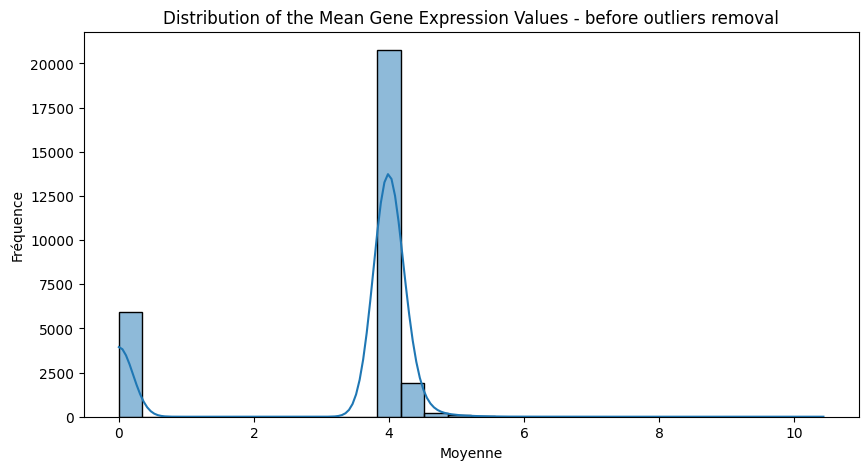

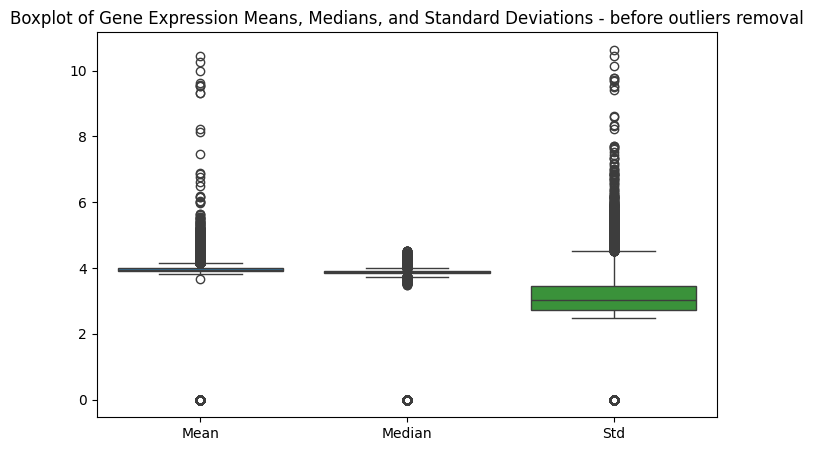

In [158]:
# Histograms 
plt.figure(figsize=(10,5))
sns.histplot(loged_genes_stats['Mean'], bins=30, kde=True)
plt.title("Distribution of the Mean Gene Expression Values - before outliers removal")
plt.xlabel("Moyenne")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=loged_genes_stats)
plt.title("Boxplot of Gene Expression Means, Medians, and Standard Deviations - before outliers removal")
plt.show()


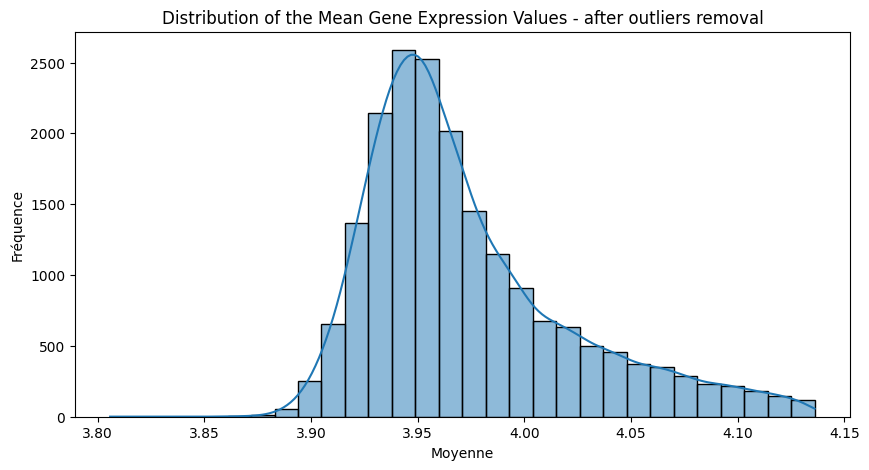

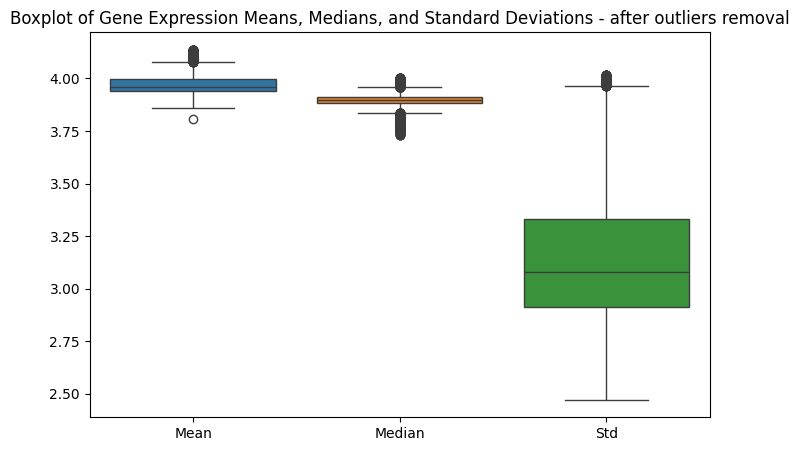

In [159]:
# Histograms 
plt.figure(figsize=(10,5))
sns.histplot(no_outliers_loged_genes_stats['Mean'], bins=30, kde=True)
plt.title("Distribution of the Mean Gene Expression Values - after outliers removal")
plt.xlabel("Moyenne")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=no_outliers_loged_genes_stats)
plt.title("Boxplot of Gene Expression Means, Medians, and Standard Deviations - after outliers removal")
plt.show()


In [160]:
# Display most variable genes
gene_stats_sorted = gene_stats.sort_values(by="Std", ascending=False)
print(gene_stats_sorted.head(10))  # Top 10 most variable genes

                Mean     Median           Std
DDX3Y   33869.112536  39.257416  41423.043353
USP9Y   28341.659163  48.489510  33906.392593
KDM5D   21641.659668  47.103328  25625.263180
TTTY15  15230.359670  48.056496  17738.821636
RPS4Y1  14177.092324  40.680322  17538.232785
TTTY14  13878.337085  68.879006  16491.336491
UTY     13708.018405  41.913263  16085.037513
ZFY     11154.803597  50.809944  13585.196087
TXLNGY  11245.763418  44.442671  13223.983507
DLK1      988.253208  49.230842  12342.021876


#### **Study of samples between ALS and Control Patient**

In [161]:
# Load the gene expression data for ALS patients
data_als = data_instance.get_data_als()

# Apply log1p transformation (log(1 + x)) to ALS data to normalize the distribution and reduce skewness
loged_data_als = np.log1p(data_als)

# Load the gene expression data for control (non-ALS) individuals
data_control = data_instance.get_data_control()

# Apply log1p transformation to control data for the same reasons (normalization and handling zeros)
loged_data_control = np.log1p(data_control)

In [162]:
# Compute descriptive statistics for ALS and Control separately (~might take 1 min)
als_stats = data_als.describe().T
control_stats = data_control.describe().T

# Add a column to show difference in mean expression
als_stats["Control_Mean"] = control_stats["mean"]
als_stats["Diff_Mean"] = np.abs(als_stats["mean"] - als_stats["Control_Mean"])

# Show top differentially expressed genes
als_stats_sorted_diff_mean = als_stats.sort_values(by="Diff_Mean", ascending=False)
print(als_stats_sorted_diff_mean.head(10))  # Genes with largest mean difference

als_stats

        count          mean           std  min  25%        50%           75%  \
DDX3Y   145.0  32288.547746  38930.894866  0.0  0.0  39.257416  65167.310436   
DLK1    145.0     58.737487     67.236244  0.0  0.0  49.230842     98.461684   
USP9Y   145.0  27847.469612  33684.177978  0.0  0.0  48.489510  57088.315935   
AGRP    145.0     62.070507     63.875473  0.0  0.0  42.858207     85.716415   
GSTM1   145.0   3394.473181   5415.272454  0.0  0.0  26.805283   6728.126098   
ZFY     145.0  10803.245372  13076.612931  0.0  0.0   0.000000  21492.606387   
TTTY14  145.0  13573.439521  16434.296589  0.0  0.0   0.000000  27827.118609   
PRG4    145.0    142.745599    386.744358  0.0  0.0  58.304540    116.609081   
UTY     145.0  13499.250282  15959.604540  0.0  0.0  41.913263  27369.360677   
TXLNGY  145.0  11037.414016  13081.184503  0.0  0.0  44.442671  21999.122240   

                  max  Control_Mean    Diff_Mean  
DDX3Y   141837.043738  41262.076874  8973.529127  
DLK1       393.84

,count,mean,std,min,25%,50%,75%,max,Control_Mean,Diff_Mean
A1BG,145.0,55.795863,30.054627,14.795904,36.989759,48.826482,63.622385,198.265108,58.754056,2.958193
A1BG-AS1,145.0,52.048585,22.402985,17.003741,38.803408,47.523275,61.475062,148.673732,50.040785,2.007800
A1CF,145.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,145.0,55.545316,29.886716,9.805041,32.296332,49.628249,73.414967,159.404508,51.548334,3.996981
A2M-AS1,145.0,52.435951,18.143741,17.224763,40.528854,48.128014,61.299891,115.000622,49.745899,2.690052
...,...,...,...,...,...,...,...,...,...,...
X8_LINE:CR1:LINE,145.0,48.954012,13.925107,19.011302,40.359189,47.368943,55.865615,125.325904,49.993318,1.039306
X9_LINE:L1:LINE,145.0,49.973362,14.880454,20.631488,39.468934,47.990636,58.754891,114.370208,48.554891,1.418471
Zaphod2:hAT-Tip100:DNA,145.0,51.112456,15.594551,16.632634,40.236299,50.753995,59.314909,116.673038,49.724318,1.388139
Zaphod3:hAT-Tip100:DNA,145.0,47.817187,14.665344,18.893355,37.940565,47.387242,54.956893,121.422116,48.106885,0.289699


In [163]:
# Apply log1p transformation (log(1 + x)) to the ALS and control statistics
loged_als_stats = np.log1p(als_stats)  # Apply log1p to ALS stats
loged_control_stats = np.log1p(control_stats)  # Apply log1p to control stats

# Find outliers in the ALS and control statistics based on the 'mean' column
als_stats_outliers = find_outliers(als_stats, 'mean')  # get outliers in ALS stats based on the mean value
control_stats_outliers = find_outliers(control_stats, 'mean')  # get outliers in control stats based on the mean value

# Drop rows corresponding to outliers from ALS and control statistics
no_outliers_loged_als_stats = loged_als_stats.drop(als_stats_outliers.index)  # Remove outliers from the log-transformed ALS stats
no_outliers_loged_control_stats = loged_control_stats.drop(control_stats_outliers.index)  # Remove outliers from the log-transformed control stats

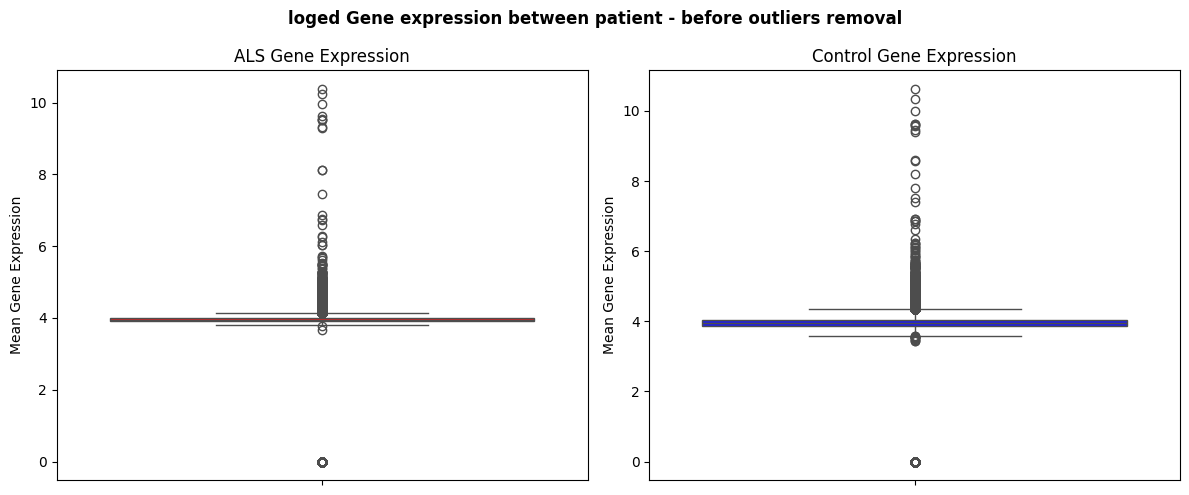

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.boxplot(data=loged_als_stats["mean"], color="red", ax=axes[0])
axes[0].set_title("ALS Gene Expression")
axes[0].set_ylabel("Mean Gene Expression")

sns.boxplot(data=loged_control_stats["mean"], color="blue", ax=axes[1])
axes[1].set_title("Control Gene Expression")
axes[1].set_ylabel("Mean Gene Expression")

plt.suptitle('loged Gene expression between patient - before outliers removal', fontweight='bold')

plt.tight_layout()
plt.show()

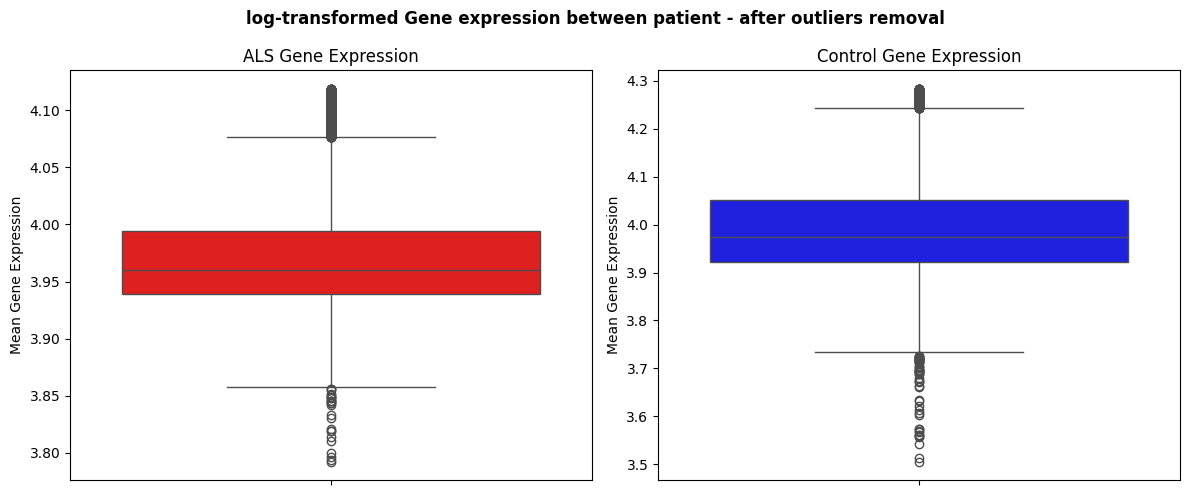

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.boxplot(data=no_outliers_loged_als_stats["mean"], color="red", ax=axes[0])
axes[0].set_title("ALS Gene Expression")
axes[0].set_ylabel("Mean Gene Expression")

sns.boxplot(data=no_outliers_loged_control_stats["mean"], color="blue", ax=axes[1])
axes[1].set_title("Control Gene Expression")
axes[1].set_ylabel("Mean Gene Expression")

plt.suptitle('log-transformed Gene expression between patient - after outliers removal', fontweight='bold')

plt.tight_layout()
plt.show()

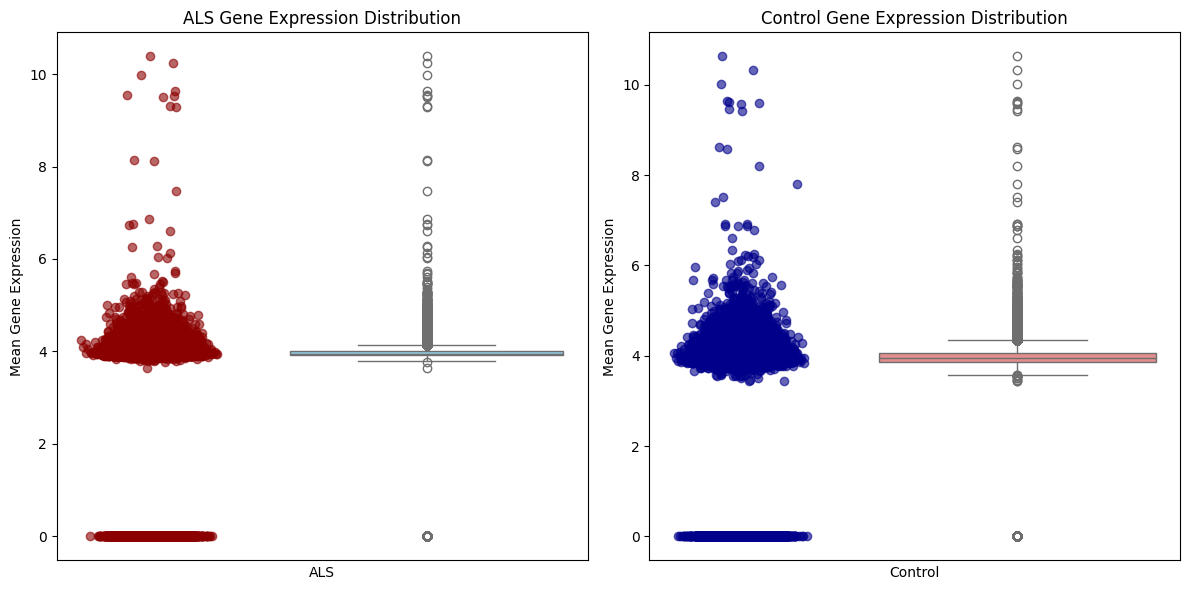

In [166]:
# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First Boxplot: ALS
sns.boxplot(data=loged_als_stats["mean"], color="skyblue", ax=axes[0])

# Add jittered points for ALS
x_als = np.random.normal(-0.8, 0.05, size=len(loged_als_stats["mean"]))  
axes[0].scatter(x_als, loged_als_stats["mean"], color="darkred", alpha=0.6)

# Set labels and title for ALS
axes[0].set_xticks([])
axes[0].set_xlabel("ALS")
axes[0].set_ylabel("Mean Gene Expression")
axes[0].set_title("ALS Gene Expression Distribution")

# Second Boxplot: Control
sns.boxplot(data=loged_control_stats["mean"], color="lightcoral", ax=axes[1])

# Add jittered points for Control
x_control = np.random.normal(-0.8 , 0.05, size=len(loged_control_stats["mean"]))  
axes[1].scatter(x_control, loged_control_stats["mean"], color="darkblue", alpha=0.6)

# Set labels and title for Control
axes[1].set_xticks([])
axes[1].set_xlabel("Control")
axes[1].set_ylabel("Mean Gene Expression")
axes[1].set_title("Control Gene Expression Distribution")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

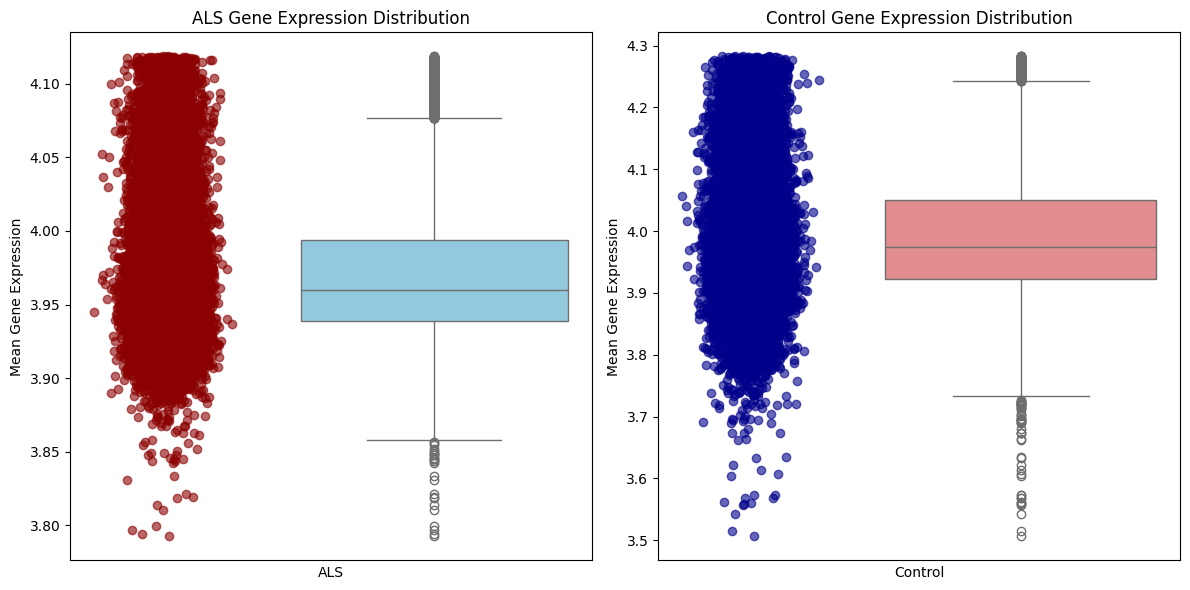

In [167]:
# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First Boxplot: ALS
sns.boxplot(data=no_outliers_loged_als_stats["mean"], color="skyblue", ax=axes[0])

# Add jittered points for ALS
x_als = np.random.normal(-0.8, 0.05, size=len(no_outliers_loged_als_stats["mean"]))  
axes[0].scatter(x_als, no_outliers_loged_als_stats["mean"], color="darkred", alpha=0.6)

# Set labels and title for ALS
axes[0].set_xticks([])
axes[0].set_xlabel("ALS")
axes[0].set_ylabel("Mean Gene Expression")
axes[0].set_title("ALS Gene Expression Distribution")

# Second Boxplot: Control
sns.boxplot(data=no_outliers_loged_control_stats["mean"], color="lightcoral", ax=axes[1])

# Add jittered points for Control
x_control = np.random.normal(-0.8 , 0.05, size=len(no_outliers_loged_control_stats["mean"]))  
axes[1].scatter(x_control, no_outliers_loged_control_stats["mean"], color="darkblue", alpha=0.6)

# Set labels and title for Control
axes[1].set_xticks([])
axes[1].set_xlabel("Control")
axes[1].set_ylabel("Mean Gene Expression")
axes[1].set_title("Control Gene Expression Distribution")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

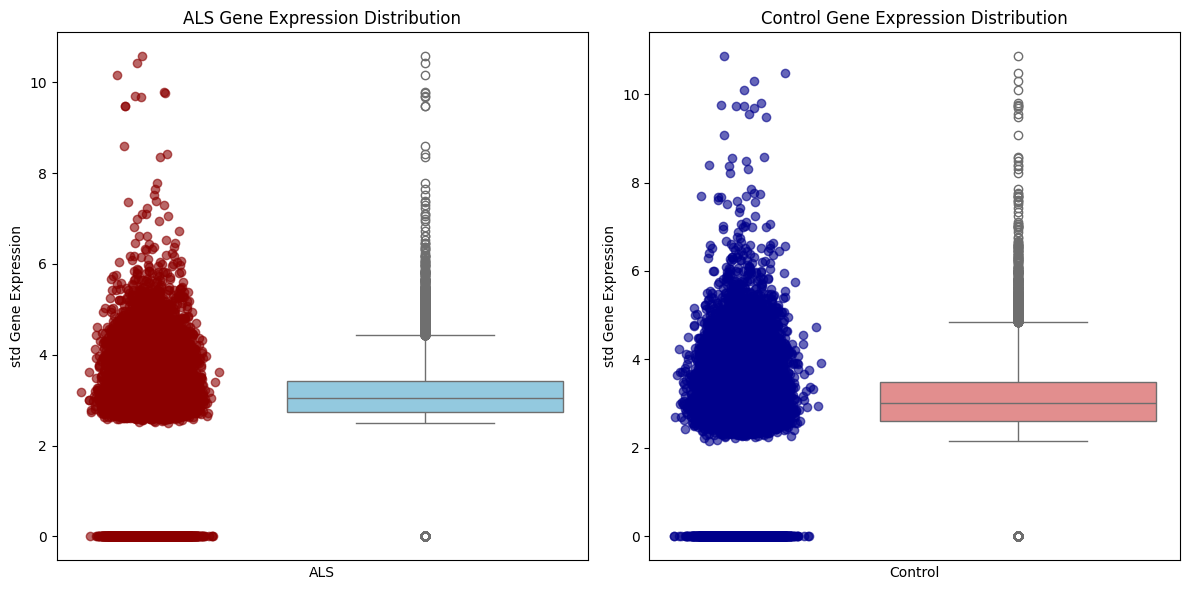

In [168]:
# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First Boxplot: ALS
sns.boxplot(data=loged_als_stats["std"], color="skyblue", ax=axes[0])

# Add jittered points for ALS
x_als = np.random.normal(-0.8, 0.05, size=len(loged_als_stats["std"]))  
axes[0].scatter(x_als, loged_als_stats["std"], color="darkred", alpha=0.6)

# Set labels and title for ALS
axes[0].set_xticks([])
axes[0].set_xlabel("ALS")
axes[0].set_ylabel("std Gene Expression")
axes[0].set_title("ALS Gene Expression Distribution")

# Second Boxplot: Control
sns.boxplot(data=loged_control_stats["std"], color="lightcoral", ax=axes[1])

# Add jittered points for Control
x_control = np.random.normal(-0.8 , 0.05, size=len(loged_control_stats["std"]))  
axes[1].scatter(x_control, loged_control_stats["std"], color="darkblue", alpha=0.6)

# Set labels and title for Control
axes[1].set_xticks([])
axes[1].set_xlabel("Control")
axes[1].set_ylabel("std Gene Expression")
axes[1].set_title("Control Gene Expression Distribution")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


#### **Testing Heatmaps of Genes Expression**

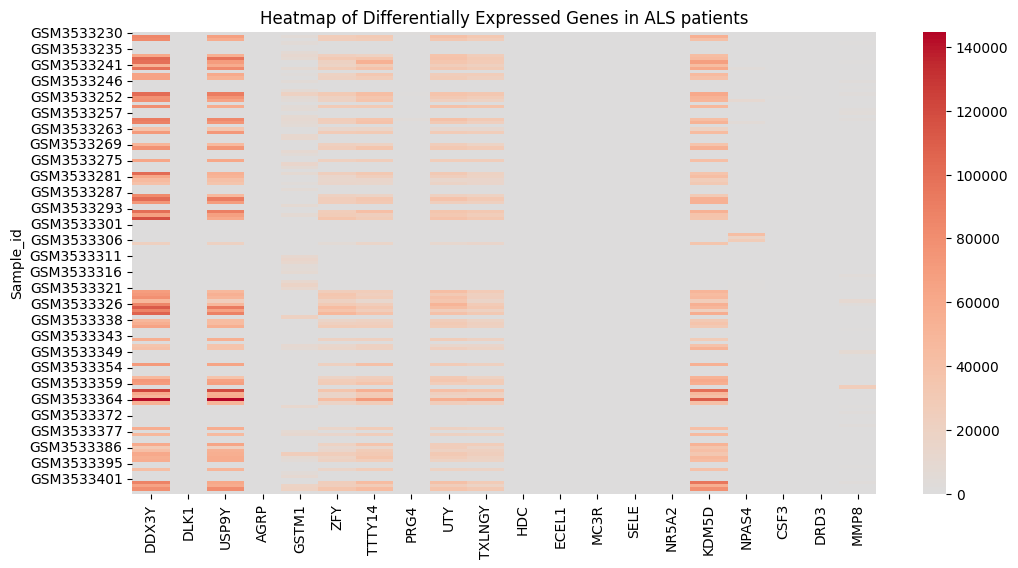

In [169]:
top_genes_als_stats = als_stats_sorted_diff_mean.head(20).index  # Select top 20 DEGs
subset_top_genes_als_stats = data_instance.get_data_als()[top_genes_als_stats]  # Extract relevant genes

plt.figure(figsize=(12,6))
sns.heatmap(subset_top_genes_als_stats, cmap="coolwarm", center=0)
plt.title("Heatmap of Differentially Expressed Genes in ALS patients")
plt.show()


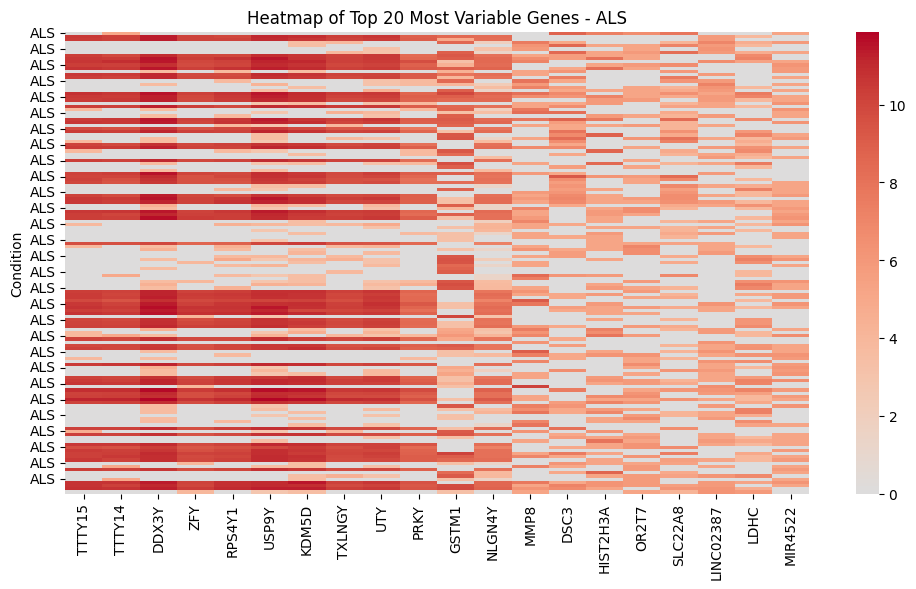

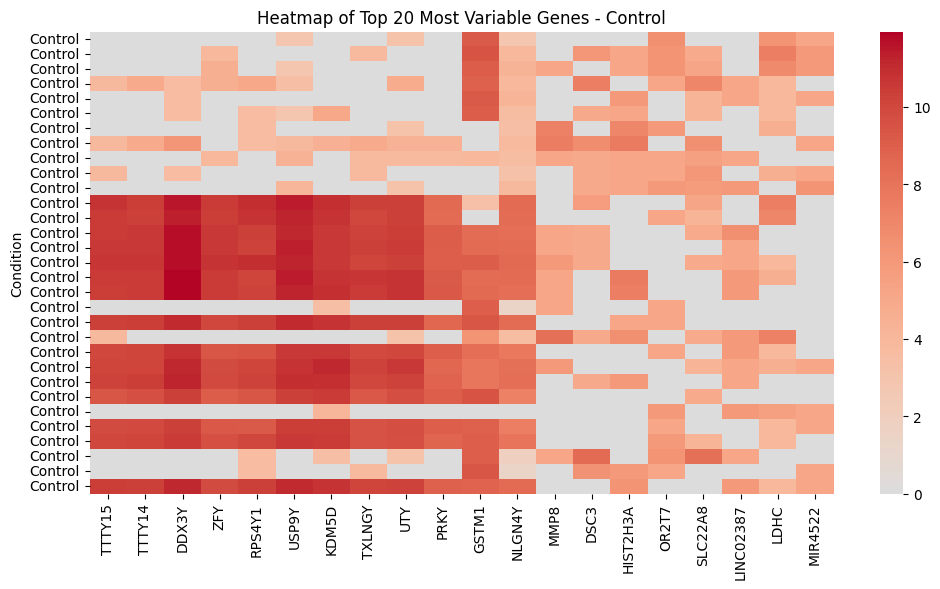

In [170]:
# Get the list of numerical columns in the log-transformed ALS data
numerical_columns_loged_data = loged_data_als.select_dtypes(include='number').columns.tolist()

# Compute the standard deviation of each gene in both ALS and control groups
std_als = loged_data_als[numerical_columns_loged_data].std()
std_control = loged_data_control[numerical_columns_loged_data].std()

# Identify the top 20 most variable genes in ALS samples based on standard deviation
top_variable_genes = std_als.nlargest(20).index  # Returns the gene names (column names)

# Extract only the top 20 genes and make copies to avoid unwanted behaviour
df_heatmap_als = loged_data_als[top_variable_genes].copy()
df_heatmap_control = loged_data_control[top_variable_genes].copy()

# Add a "Condition" column to label the samples as ALS or Control
df_heatmap_als.loc[:, "Condition"] = ["ALS"] * len(loged_data_als)
df_heatmap_control.loc[:, "Condition"] = ["Control"] * len(loged_data_control)

# Set "Condition" as the index for better grouping in the heatmap
df_heatmap_als = df_heatmap_als.set_index("Condition")
df_heatmap_control = df_heatmap_control.set_index("Condition")

# Plot heatmap for ALS samples
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap_als, cmap="coolwarm", center=0)
plt.title("Heatmap of Top 20 Most Variable Genes - ALS")
plt.show()

# Plot heatmap for Control samples
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap_control, cmap="coolwarm", center=0)
plt.title("Heatmap of Top 20 Most Variable Genes - Control")
plt.show()

In [171]:
def heatmap_comparison(set_of_genes, df1, df2):
    # Extract relevant genes
    df1_subset = df1[set_of_genes]  
    df2_subset = df2[set_of_genes]

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot ALS heatmap
    sns.heatmap(df1_subset, cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title("ALS Patients")

    # Plot Control heatmap
    sns.heatmap(df2_subset, cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("Control Patients")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

#### **Clustered heatmaps for better visualisation**

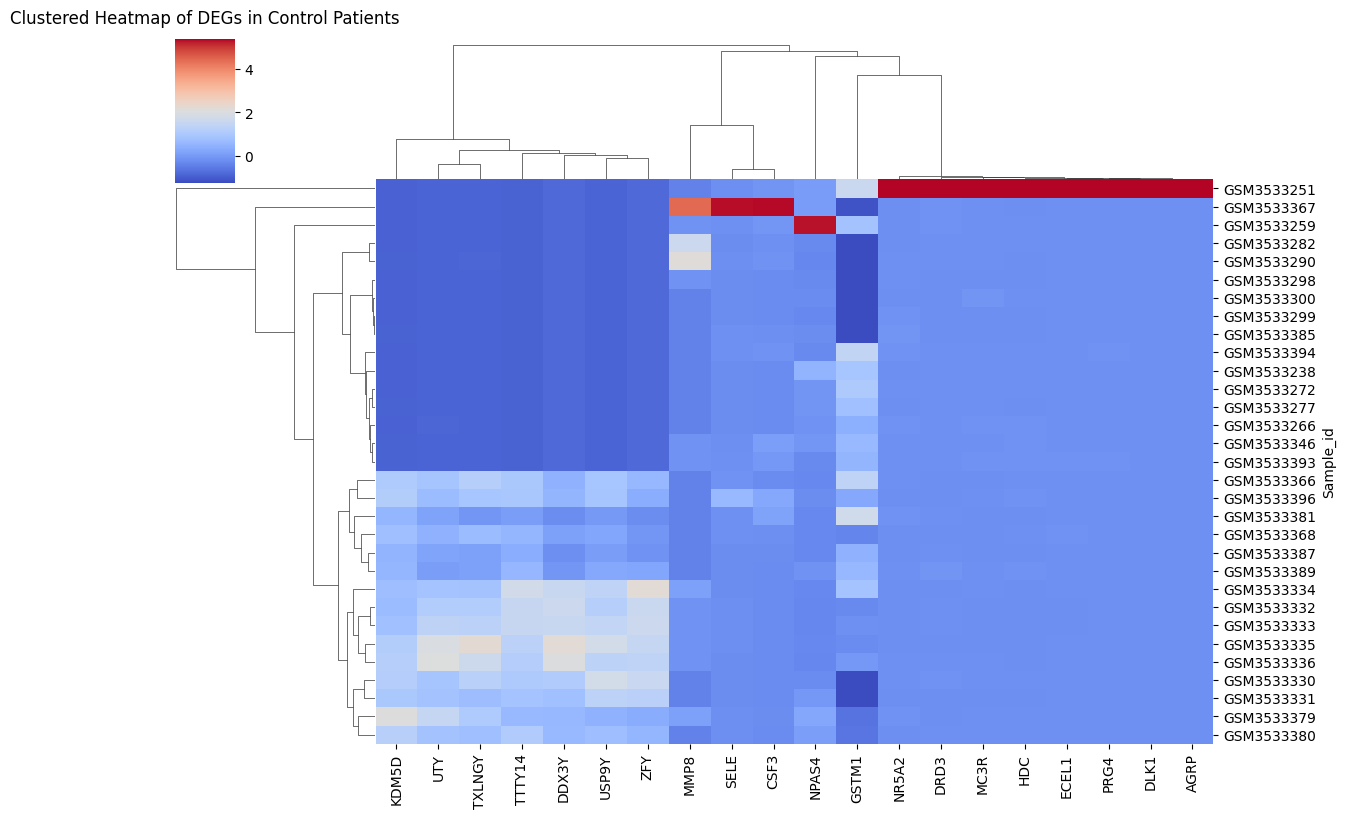

In [172]:
top_genes = als_stats_sorted_diff_mean.head(20).index
subset_top_genes_control_data = data_instance.get_data_control()[top_genes]

# Standardize data (optional but useful for heatmaps)
df_standardized = (subset_top_genes_control_data - subset_top_genes_control_data.mean()) / subset_top_genes_control_data.std()

# Plot with clustermap
sns.clustermap(df_standardized, cmap="coolwarm", figsize=(12, 8), 
               metric='euclidean', method='average', 
               z_score=None, col_cluster=True, row_cluster=True)

plt.title("Clustered Heatmap of DEGs in Control Patients", y=1.05)
plt.show()

#### **Boxplot of Genes Expression for comparison**

In [173]:
boxplot_comparison_data = data_instance.get_mrn_data_genes()

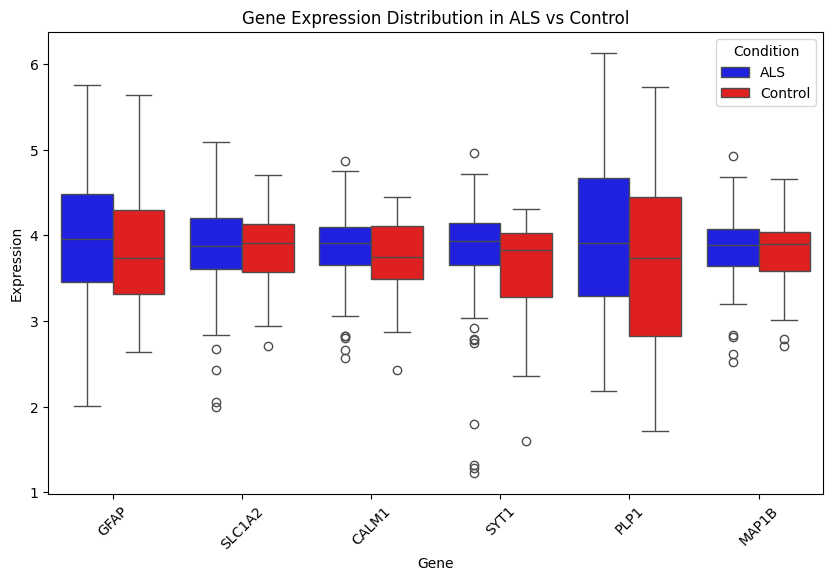

In [174]:
# Selection of a few genes for visualization
selected_genes = ["GFAP", "SLC1A2", "CALM1", "SYT1", "PLP1", "MAP1B"]  # Replace with actual gene names

data_als["Condition"] = "ALS"
data_control["Condition"] = "Control"

loged_data_als["Condition"] = "ALS"
loged_data_control["Condition"] = "Control"

df_combined = pd.concat([data_als, data_control])
loged_combined = pd.concat([loged_data_als, loged_data_control])
# Convert data to long format for seaborn
df_long = loged_combined.melt(id_vars=["Condition"], value_vars=selected_genes, var_name="Gene", value_name="Expression")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Gene", y="Expression", hue="Condition", data=df_long, palette=["blue", "red"])
plt.title("Gene Expression Distribution in ALS vs Control")
plt.xticks(rotation=45)
plt.show()


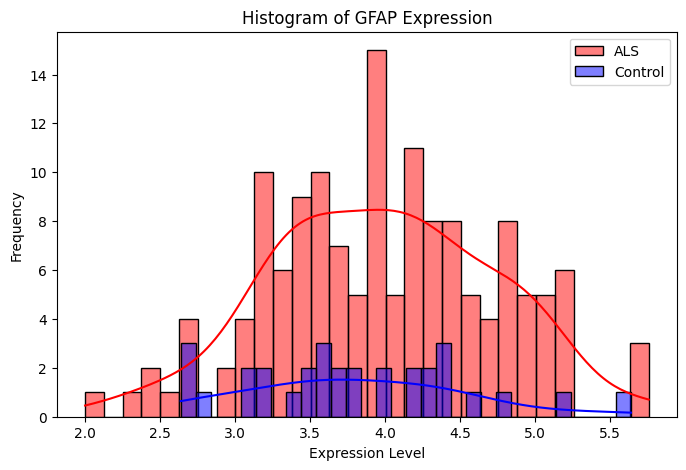

In [175]:
gene_of_interest = "GFAP"  # Replace with actual gene name

plt.figure(figsize=(8, 5))
sns.histplot(loged_data_als[gene_of_interest], color="red", label="ALS", kde=True, bins=30)
sns.histplot(loged_data_control[gene_of_interest], color="blue", label="Control", kde=True, bins=30)
plt.title(f"Histogram of {gene_of_interest} Expression")
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Step 3

In [176]:
# Initialize a StandardScaler to normalize the data (zero mean and unit variance)
scaler = StandardScaler()

# Retrieve the normalized gene expression data (genes in columns, samples in rows)
pca_data = data_instance.get_mrn_data_genes()

# Remove columns (genes) with zero variance to avoid issues in PCA
pca_data = pca_data.loc[:, pca_data.var() > 0]

# Apply standard scaling to the data so each gene has mean 0 and std 1
# This is important for PCA to work properly
X = scaler.fit_transform(pca_data)
X

array([[ 0.19251575,  0.63398434,  0.68375795, ...,  1.2625332 ,
         1.06112223,  1.45131029],
       [-0.63866337, -0.24099928, -0.52435513, ...,  1.11502969,
         1.08714238,  1.1101587 ],
       [-0.88312782, -0.4909946 , -0.4906221 , ...,  0.51682101,
         0.22414049,  0.08670394],
       ...,
       [ 1.26815933,  3.57142936,  1.80165479, ..., -0.5648714 ,
        -0.58898943, -0.54452863],
       [ 4.20173273,  4.44641298,  0.83202637, ...,  0.71349236,
         0.19595199,  0.2113162 ],
       [ 1.85487401,  1.55063385,  1.429807  , ...,  0.09069976,
         0.13740664,  0.0315477 ]])

In [177]:
# Define a list of component names for labeling the first 10 principal components
components = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]

In [178]:
# Initialize PCA to reduce the dimensionality to 10 components
pca = PCA(n_components=10)

# Fit PCA on the standardized data and transform it to principal components
principal_components = pca.fit_transform(X)

# Convert the resulting PCA-transformed data to a DataFrame
# Each column represents a principal component (PC1 to PC10)
# Rows are indexed by sample names 
df_pca = pd.DataFrame(principal_components, columns=components, index=pca_data.index)

# Get the amount of variance explained by each of the 10 components
explained_variance = pca.explained_variance_ratio_

# Print the explained variance ratio to understand how much information each PC captures
print("Explained Variance Ratios:", explained_variance)

Explained Variance Ratios: [0.36046468 0.10176639 0.09169767 0.05664559 0.03088848 0.02800851
 0.01980053 0.01819644 0.01305778 0.01017248]


In [179]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Sample_id,,,,,,,,,,
GSM3533230,62.189174,-12.897833,11.867563,56.248413,73.216364,18.947124,-45.708106,-36.097478,0.953194,-1.116013
GSM3533231,-27.252140,1.192609,-13.358047,42.324446,-16.980912,-9.046461,-12.474361,10.448242,19.289517,-1.707292
GSM3533232,-54.085294,15.836061,-33.928655,30.355929,-12.881988,-1.170890,-4.387911,7.034676,22.413322,-2.081990
GSM3533233,-60.384630,-14.240843,30.185720,52.233838,-18.956424,24.258758,2.427026,6.973595,15.906621,-5.032570
GSM3533234,-19.105174,-20.943224,-44.124193,61.532352,-11.558458,51.674314,-10.110904,3.750239,26.360050,-13.951647
...,...,...,...,...,...,...,...,...,...,...
GSM3533401,-101.016499,-28.157803,7.609165,-39.095586,-10.347579,-10.028547,-8.305091,2.585163,13.537476,1.979057
GSM3533402,248.515883,31.151562,164.502248,-87.354966,-25.124260,55.818307,-54.869971,-22.943070,19.236324,-8.462155
GSM3533403,147.197780,-69.459740,45.074689,-93.555580,-30.418779,14.538953,17.915514,-45.237740,21.414428,-2.265375


In [180]:
# Retrieve the sample group labels from the data matrix (e.g., "ALS", "Control", etc.)
df_labels = data_instance.get_data_matrix()['Sample_group']

# Display the unique sample group values to see the different categories present
df_labels.unique()

array(['ALS Spectrum MND', 'Non-Neurological Control',
       'Other Neurological Disorders'], dtype=object)

In [181]:
# Retrieve the sample group labels from the data matrix (e.g., "ALS", "Control", etc.)
df_labels = data_instance.get_data_matrix()['Sample_group']

# Merge the PCA DataFrame with the sample labels based on the index (sample names)
# This allows to associate each sample with its respective group (e.g., ALS or Control)
df_pca = df_pca.merge(df_labels, left_index=True, right_index=True)

# Display the updated DataFrame, now including the sample group labels along with PCA components
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Sample_group
Sample_id,,,,,,,,,,,
GSM3533230,62.189174,-12.897833,11.867563,56.248413,73.216364,18.947124,-45.708106,-36.097478,0.953194,-1.116013,ALS Spectrum MND
GSM3533231,-27.252140,1.192609,-13.358047,42.324446,-16.980912,-9.046461,-12.474361,10.448242,19.289517,-1.707292,ALS Spectrum MND
GSM3533232,-54.085294,15.836061,-33.928655,30.355929,-12.881988,-1.170890,-4.387911,7.034676,22.413322,-2.081990,ALS Spectrum MND
GSM3533233,-60.384630,-14.240843,30.185720,52.233838,-18.956424,24.258758,2.427026,6.973595,15.906621,-5.032570,ALS Spectrum MND
GSM3533234,-19.105174,-20.943224,-44.124193,61.532352,-11.558458,51.674314,-10.110904,3.750239,26.360050,-13.951647,ALS Spectrum MND
...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,-101.016499,-28.157803,7.609165,-39.095586,-10.347579,-10.028547,-8.305091,2.585163,13.537476,1.979057,ALS Spectrum MND
GSM3533402,248.515883,31.151562,164.502248,-87.354966,-25.124260,55.818307,-54.869971,-22.943070,19.236324,-8.462155,ALS Spectrum MND
GSM3533403,147.197780,-69.459740,45.074689,-93.555580,-30.418779,14.538953,17.915514,-45.237740,21.414428,-2.265375,ALS Spectrum MND


In [182]:
# Define color mapping for categories
color_map = {"ALS Spectrum MND": "red", "Non-Neurological Control": "blue", 'Other Neurological Disorders' : 'yellow'}
df_pca["Color"] = df_pca["Sample_group"].map(color_map)

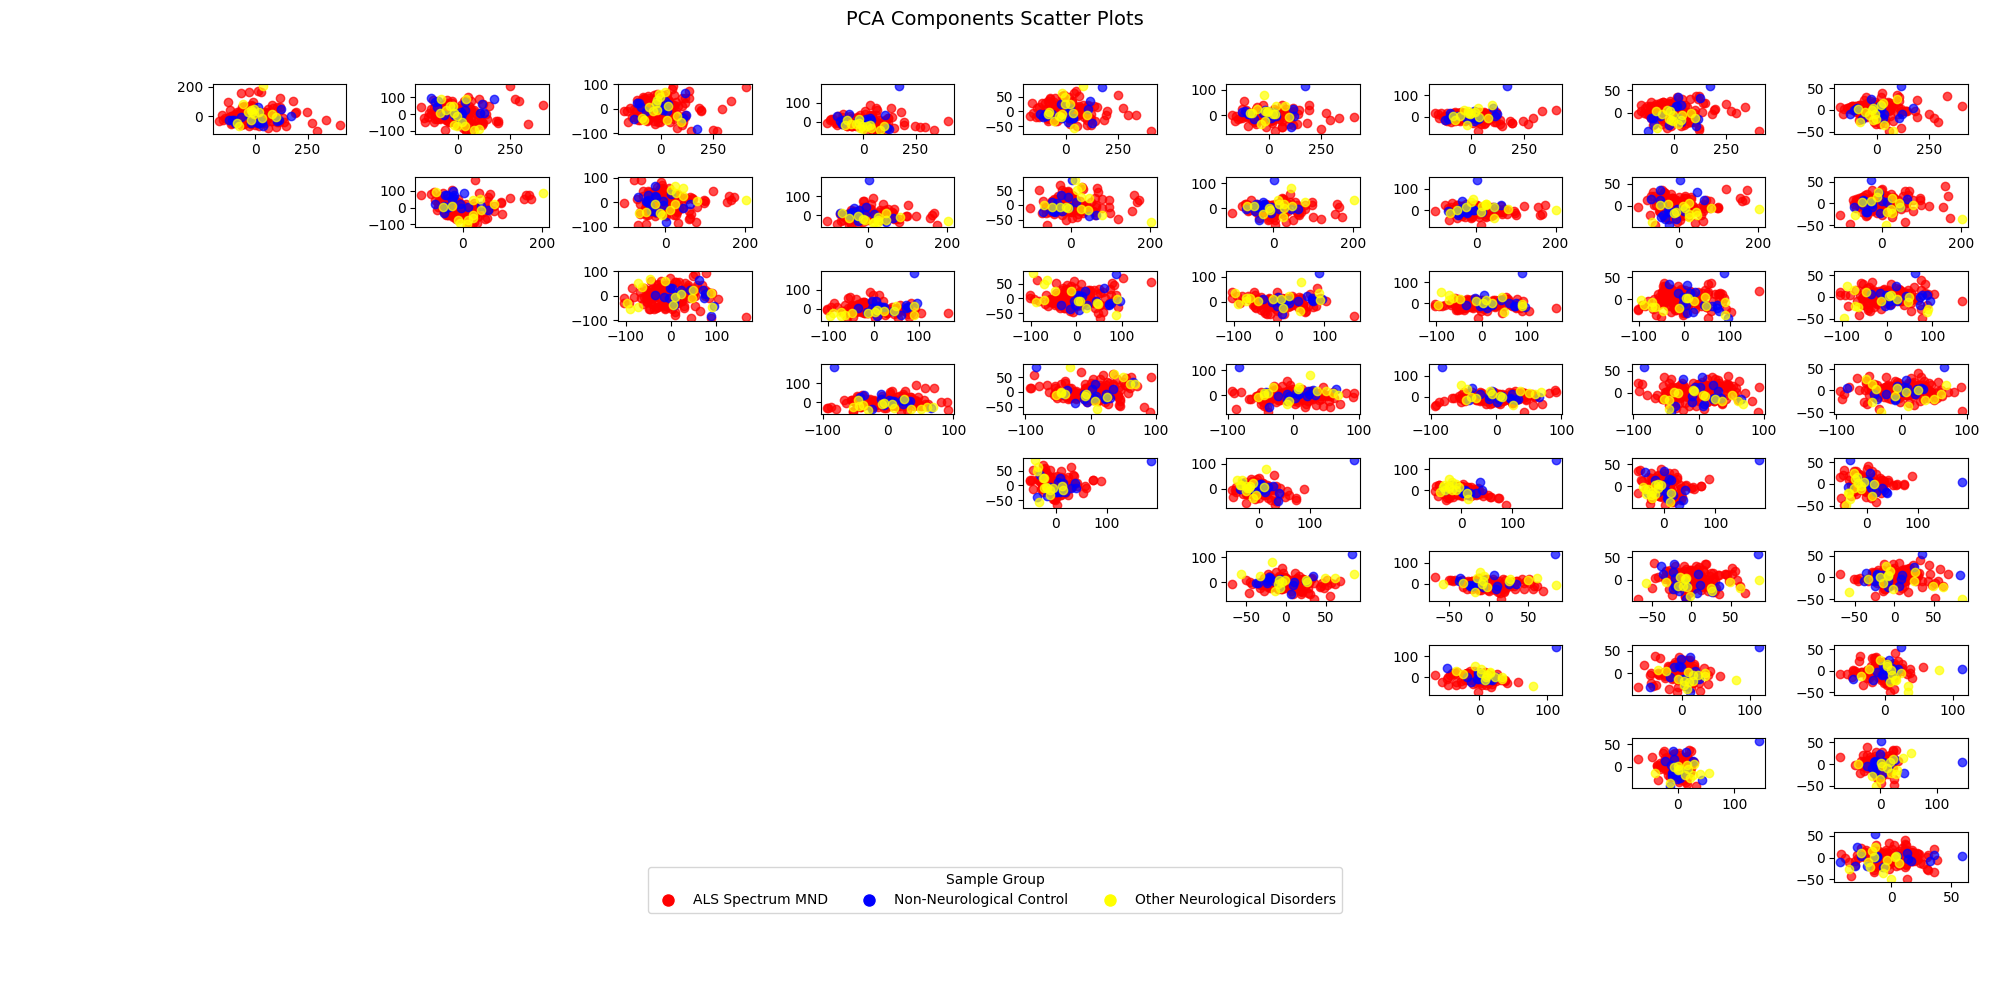

In [183]:
# Scatter plot of PCA results
fig, axs = plt.subplots(10, 10, figsize=(20, 10))
fig.suptitle('PCA Components Scatter Plots', fontsize=14)
for i in range(10):
    for j in range(10) :
        if j <= i :
            axs[i,j].axis("off")
        else :
            for label in df_pca["Sample_group"].unique():
                subset = df_pca[df_pca["Sample_group"] == label]
                axs[i, j].scatter(subset[components[i]], subset[components[j]], label=label, color=color_map[label], alpha=0.7)
        
# Dummy plot just for the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                      markersize=10, markerfacecolor=color_map[label]) 
           for label in color_map]

# Global legend 
fig.legend(handles=handles, title='Sample Group', loc='center', fontsize=10, bbox_to_anchor=(0.5, 0.1), ncol=3)

# Adjust layout to prevent overlap and allow space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.96])  

## Step 5

In [184]:
# Retrieve the gene expression data, where rows represent samples and columns represent genes
counts_df = data_instance.get_data_genes()

# Retrieve the metadata that contains the sample group information (e.g., "ALS", "Control")
metadata = data_instance.get_data_matrix()[['Sample_group']]

In [185]:
# Create a boolean mask to filter out rows where the 'Sample_group' is NaN
# "~" operator to invert the true/false of the mask 
samples_to_keep = ~metadata.Sample_group.isna()

# Apply the mask to the gene expression data to retain only samples with non-missing group labels
counts_df = counts_df.loc[samples_to_keep]

# Apply the same mask to the metadata, ensuring only valid samples are kept
metadata = metadata.loc[samples_to_keep]

In [186]:
counts_df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
Sample_id,,,,,,,,,,,,,,,,,,,,,
GSM3533230,42,149,0,3327,101,78,4,0,67,0,...,986,2218,2096,1120,84,556,134,570,2045,2446
GSM3533231,25,107,2,1787,153,109,2,1,25,0,...,1216,2373,2001,1144,118,582,153,552,2057,2279
GSM3533232,20,95,0,1830,121,127,1,1,11,0,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533233,22,101,0,2131,142,143,5,1,36,0,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533234,22,102,0,1706,83,178,1,3,31,0,...,966,2295,1993,1152,96,582,124,539,1742,1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533401,23,113,0,2130,72,71,2,3,21,0,...,553,1243,1089,658,72,320,73,311,1102,1169
GSM3533402,134,300,0,6077,171,42,8,5,225,0,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533403,64,290,0,4752,118,174,8,2,135,0,...,623,1466,1246,726,61,358,107,347,1284,1469


In [187]:
metadata

,Sample_group
Sample_id,
GSM3533230,ALS Spectrum MND
GSM3533231,ALS Spectrum MND
GSM3533232,ALS Spectrum MND
GSM3533233,ALS Spectrum MND
GSM3533234,ALS Spectrum MND
...,...
GSM3533401,ALS Spectrum MND
GSM3533402,ALS Spectrum MND
GSM3533403,ALS Spectrum MND


In [188]:
# Create a boolean mask that selects columns (genes) from `counts_df` where genes
# that have at least 10 non-zero counts across all samples will be kept
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]

# Use the mask to filter out genes that don't meet the criteria
# Only genes that pass the threshold (>= 10 total counts) will remain in the DataFrame
counts_df = counts_df[genes_to_keep]

In [189]:
# Set the number of CPUs to use (adjust as per your machine)
inference = DefaultInference(n_cpus=8)

# Create the DESeqDataSet object
deseq_instance = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~Sample_group",  # 'Sample_group' will be used to compare the conditions
    refit_cooks=True,
    inference=inference,
)

In [190]:
deseq_instance.deseq2() # applies the DESeq2 method for differential expression analysis on the `deseq_instance` object

Fitting size factors...
... done in 0.13 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 69.82 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 82.91 seconds.

Fitting LFCs...
... done in 7.15 seconds.

Calculating cook's distance...
... done in 0.97 seconds.

Replacing 221 outlier genes.

Fitting dispersions...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 0.45 seconds.

Fitting LFCs...
... done in 0.12 seconds.



In [191]:
# Define the contrast for differential expression analysis: comparing two conditions
# "ALS Spectrum MND" vs "Non-Neurological Control" by specifying the sample group
contrast_als_control = ["Sample_group", "ALS Spectrum MND", "Non-Neurological Control"]

# Create an instance of `DeseqStats` to perform differential expression analysis
deseq_als_vs_control = DeseqStats(
    deseq_instance,
    contrast=contrast_als_control,
    alpha=0.05,  # Significance threshold for p-value
    cooks_filter=True,  # Apply Cook's distance to filter outliers
    independent_filter=True,  # Apply independent filtering for lowly expressed genes
)

# Display a summary of the differential expression analysis results
deseq_als_vs_control.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Sample_group ALS Spectrum MND vs Non-Neurological Control
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993900       -0.018093  0.142810 -0.126694   
A1BG-AS1                 113.742744       -0.052955  0.099424 -0.532623   
A1CF                       0.155759        0.590127  1.757745  0.335729   
A2M                     2345.384521       -0.119105  0.160232 -0.743329   
A2M-AS1                   99.268402        0.186468  0.097540  1.911716   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.854980       -0.058600  0.103594 -0.565669   
X9_LINE:L1:LINE          109.576019        0.073868  0.110992  0.665525   
Zaphod2:hAT-Tip100:DNA   411.010284       -0.065305  0.105699 -0.617834   
Zaphod3:hAT-Tip100:DNA  1539.491089       -0.107348  0.107347 -1.000003   
Zaphod:hAT-Tip100:DNA   1710.104370       -0.084252  0.096951 -0.869016   

   

... done in 2.79 seconds.



In [192]:
# Retrieve the results DataFrame from the `deseq_als_vs_control` object
# that contains the results of the differential expression analysis for ALS vs Control comparison
res_data_als_vs_control = deseq_als_vs_control.results_df

# Display the results DataFrame to examine the differential expression results
res_data_als_vs_control

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,35.993900,-0.018093,0.142810,-0.126694,0.899182,0.956135
A1BG-AS1,113.742744,-0.052955,0.099424,-0.532623,0.594294,0.780092
A1CF,0.155759,0.590127,1.757745,0.335729,0.737075,NaN
A2M,2345.384521,-0.119105,0.160232,-0.743329,0.457283,0.680841
A2M-AS1,99.268402,0.186468,0.097540,1.911716,0.055913,0.205327
...,...,...,...,...,...,...
X8_LINE:CR1:LINE,458.854980,-0.058600,0.103594,-0.565669,0.571619,0.765036
X9_LINE:L1:LINE,109.576019,0.073868,0.110992,0.665525,0.505715,0.717554
Zaphod2:hAT-Tip100:DNA,411.010284,-0.065305,0.105699,-0.617834,0.536685,0.741030
Zaphod3:hAT-Tip100:DNA,1539.491089,-0.107348,0.107347,-1.000003,0.317309,0.560354


In [193]:
# Define the contrast for differential expression analysis: comparing two conditions
# "ALS Spectrum MND" vs "Other Neurological Disorders" by specifying the sample group
contrast_als_other_neuro = ["Sample_group", "ALS Spectrum MND", "Other Neurological Disorders"]

# Create an instance of `DeseqStats` to perform differential expression analysis
deseq_als_vs_other_neuro = DeseqStats(
    deseq_instance,
    contrast=contrast_als_other_neuro,
    alpha=0.05,  # Significance threshold for p-value
    cooks_filter=True,  # Apply Cook's distance to filter outliers
    independent_filter=True,  # Apply independent filtering for lowly expressed genes
)

# Display a summary of the differential expression analysis results
deseq_als_vs_other_neuro.summary()

Running Wald tests...
... done in 2.84 seconds.



Log2 fold change & Wald test p-value: Sample_group ALS Spectrum MND vs Other Neurological Disorders
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993900       -0.133736  0.154884 -0.863463   
A1BG-AS1                 113.742744        0.106113  0.109191  0.971812   
A1CF                       0.155759        0.364436  1.889572  0.192867   
A2M                     2345.384521        0.306505  0.174980  1.751656   
A2M-AS1                   99.268402       -0.045173  0.105309 -0.428955   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.854980        0.003441  0.113142  0.030411   
X9_LINE:L1:LINE          109.576019        0.028600  0.120971  0.236419   
Zaphod2:hAT-Tip100:DNA   411.010284        0.124907  0.115590  1.080603   
Zaphod3:hAT-Tip100:DNA  1539.491089        0.081647  0.117241  0.696400   
Zaphod:hAT-Tip100:DNA   1710.104370        0.089159  0.105887  0.842018   


In [194]:
# Retrieve the results DataFrame from the `deseq_als_vs_control` object
# that contains the results of the differential expression analysis for ALS vs Other Neurological Disorders comparison
res_data_als_vs_other_neuro = deseq_als_vs_other_neuro.results_df

# Display the results DataFrame to examine the differential expression results
res_data_als_vs_other_neuro

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,35.993900,-0.133736,0.154884,-0.863463,0.387883,0.703735
A1BG-AS1,113.742744,0.106113,0.109191,0.971812,0.331144,0.660073
A1CF,0.155759,0.364436,1.889572,0.192867,0.847063,NaN
A2M,2345.384521,0.306505,0.174980,1.751656,0.079833,0.347115
A2M-AS1,99.268402,-0.045173,0.105309,-0.428955,0.667956,0.870466
...,...,...,...,...,...,...
X8_LINE:CR1:LINE,458.854980,0.003441,0.113142,0.030411,0.975739,0.994607
X9_LINE:L1:LINE,109.576019,0.028600,0.120971,0.236419,0.813107,0.936014
Zaphod2:hAT-Tip100:DNA,411.010284,0.124907,0.115590,1.080603,0.279874,0.614303
Zaphod3:hAT-Tip100:DNA,1539.491089,0.081647,0.117241,0.696400,0.486178,0.772876


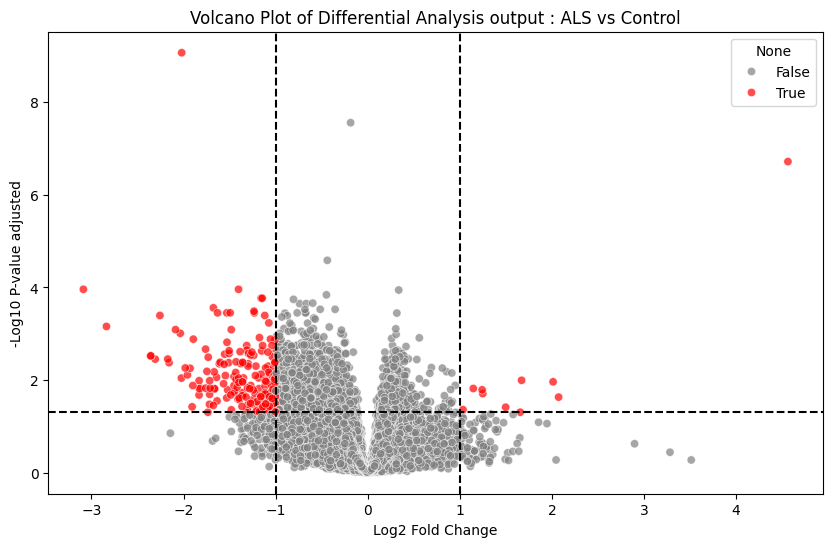

In [195]:
# Add a column for -log10(p-value)
res_data_als_vs_control['-log10p'] = -np.log10(res_data_als_vs_control['padj'])

# Set thresholds for significance
significance_threshold = 0.05
log2_fc_threshold = 1  # Adjust based on your data

# Create a volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=res_data_als_vs_control,
    x='log2FoldChange',
    y='-log10p',
    hue=(res_data_als_vs_control['padj'] < significance_threshold) & (abs(res_data_als_vs_control['log2FoldChange']) > log2_fc_threshold),
    palette={True: 'red', False: 'grey'},
    alpha=0.7
)

# Add threshold lines for significance
plt.axhline(y=-np.log10(significance_threshold), color='black', linestyle='--')  # p-value threshold
plt.axvline(x=-log2_fc_threshold, color='black', linestyle='--')  # log2 fold change threshold
plt.axvline(x=log2_fc_threshold, color='black', linestyle='--')  # log2 fold change threshold

# Customize the plot
plt.title('Volcano Plot of Differential Analysis output : ALS vs Control')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value adjusted')
plt.show()


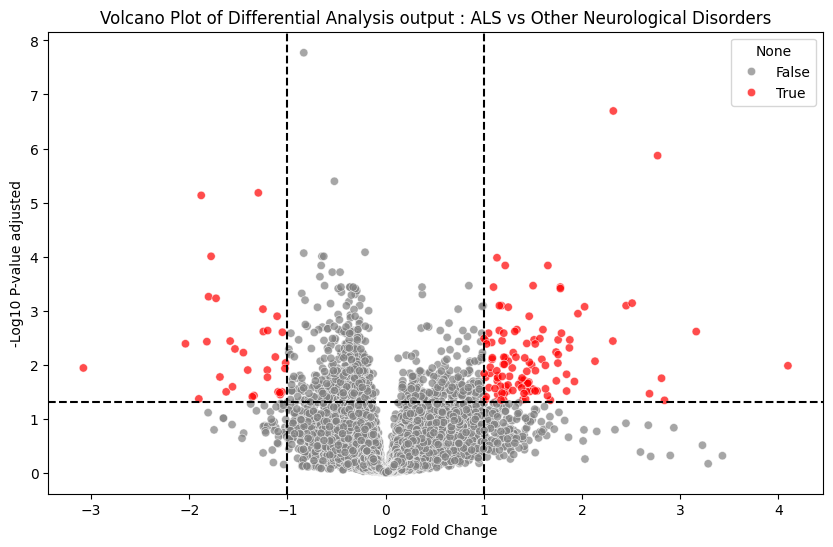

In [196]:
# Add a column for -log10(p-value)
res_data_als_vs_other_neuro['-log10p'] = -np.log10(res_data_als_vs_other_neuro['padj'])

# Set thresholds for significance
significance_threshold = 0.05
log2_fc_threshold = 1  # Adjust based on your data

# Create a volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=res_data_als_vs_other_neuro,
    x='log2FoldChange',
    y='-log10p',
    hue=(res_data_als_vs_other_neuro['padj'] < significance_threshold) & (abs(res_data_als_vs_other_neuro['log2FoldChange']) > log2_fc_threshold),
    palette={True: 'red', False: 'grey'},
    alpha=0.7
)

# Add threshold lines for significance
plt.axhline(y=-np.log10(significance_threshold), color='black', linestyle='--')  # p-value threshold
plt.axvline(x=-log2_fc_threshold, color='black', linestyle='--')  # log2 fold change threshold
plt.axvline(x=log2_fc_threshold, color='black', linestyle='--')  # log2 fold change threshold

# Customize the plot
plt.title('Volcano Plot of Differential Analysis output : ALS vs Other Neurological Disorders')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value adjusted')
plt.show()

In [197]:
# Filter out the outliers from previous the results for ALS vs Control comparison
outliers_als_vs_control_volcano = res_data_als_vs_control[
    (res_data_als_vs_control['padj'] < significance_threshold) &  # Adjusted p-value less than significance threshold
    (abs(res_data_als_vs_control['log2FoldChange']) > log2_fc_threshold)  # Absolute log2 fold change greater than threshold
]

# Similarly, filter out the outliers from the results for ALS vs Other Neurological condition comparison
outliers_als_vs_neuro_volcano = res_data_als_vs_other_neuro[
    (res_data_als_vs_other_neuro['padj'] < significance_threshold) &  # Adjusted p-value less than significance threshold
    (abs(res_data_als_vs_other_neuro['log2FoldChange']) > log2_fc_threshold)  # Absolute log2 fold change greater than threshold
]

In [201]:
# Calculate a combined 'Ordre' score for each outlier based on the absolute value of log2 fold change and adjusted p-value.
# The 'Ordre' score is a weighted sum where both log2 fold change and adjusted p-value contribute equally.
# This score helps prioritize genes based on both their magnitude of expression change and statistical significance.
outliers_als_vs_control_volcano = outliers_als_vs_control_volcano.copy() ## make copy to avoid unwanted behavior
outliers_als_vs_neuro_volcano = outliers_als_vs_neuro_volcano.copy() ## make copy to avoid unwanted behavior
# For ALS vs Control outliers, calculate 'Ordre' as a weighted sum of abs(log2FoldChange) and abs(padj)
outliers_als_vs_control_volcano.loc[:, 'Ordre'] = abs(outliers_als_vs_control_volcano['log2FoldChange']) * 0.5 + abs(outliers_als_vs_control_volcano['padj']) * 0.5

# Similarly, calculate 'Ordre' for ALS vs Other Neurological conditions outliers
outliers_als_vs_neuro_volcano.loc[:, 'Ordre'] = abs(outliers_als_vs_neuro_volcano['log2FoldChange']) * 0.5 + abs(outliers_als_vs_neuro_volcano['padj']) * 0.5

In [202]:
# Sorting the DataFrame `outliers_als_vs_control_volcano` by the 'Ordre' column in descending order
sorted_res_als_vs_control = outliers_als_vs_control_volcano.sort_values(by='Ordre', ascending=False)

# Sorting the DataFrame `outliers_als_vs_neuro_volcano` by the 'Ordre' column in descending order
sorted_res_als_vs_other_neuro = outliers_als_vs_neuro_volcano.sort_values(by='Ordre', ascending=False)

In [203]:
sorted_res_als_vs_control ## check the order

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10p,Ordre
MAPK8IP1P2,45.719131,4.562164,0.682911,6.680468,2.381803e-11,1.914017e-07,6.718054,2.281082
CCL8,1.094456,-3.087401,0.555472,-5.558159,2.726345e-08,1.095445e-04,3.960409,1.543755
CSF3,5.875627,-2.836973,0.582678,-4.868854,1.122470e-06,6.938592e-04,3.158729,1.418834
SPATA31A5,0.589098,-2.355787,0.553104,-4.259209,2.051518e-05,2.997455e-03,2.523247,1.179392
SPATA31A7,0.589098,-2.355787,0.553104,-4.259209,2.051518e-05,2.997455e-03,2.523247,1.179392
...,...,...,...,...,...,...,...,...
CDC42BPG,2.725452,-1.002056,0.275667,-3.635025,2.779533e-04,1.132699e-02,1.945886,0.506692
CYP21A1P,5.708154,-1.003906,0.268832,-3.734319,1.882240e-04,9.356091e-03,2.028906,0.506631
ZDHHC19,5.376015,-1.008266,0.245512,-4.106786,4.012031e-05,4.129701e-03,2.384081,0.506198
LY6G5B,31.311668,-1.006916,0.219052,-4.596694,4.292483e-06,1.361621e-03,2.865944,0.504139


In [205]:
# Finding the intersection of the gene indices from both comparisons (ALS vs Control, ALS vs Other Neuro conditions)
# This will return genes that are common (i.e., significant) in both the ALS vs Control and ALS vs Other Neuro comparisons
most_relevant_genes_deseq = sorted_res_als_vs_control.index.intersection(sorted_res_als_vs_other_neuro.index)

# Printing the most relevant genes that are common between both comparisons
print(most_relevant_genes_deseq)

Index(['IL1B', 'CXCL1', 'ADGRE1', 'STC1', 'PIK3CD-AS2', 'SECTM1', 'AMN'], dtype='object')


In [207]:
relevant_genes_order_als_control = sorted_res_als_vs_control.loc[most_relevant_genes_deseq]
relevant_genes_order_als_other_neuro = sorted_res_als_vs_other_neuro.loc[most_relevant_genes_deseq]

# Display the rows for the common genes
print("Rows from cm:")
print(relevant_genes_order_als_control['Ordre'])

print("\nRows from cnm:")
print(relevant_genes_order_als_other_neuro['Ordre'])

Rows from cm:
IL1B          0.881331
CXCL1         0.778033
ADGRE1        0.676473
STC1          0.672160
PIK3CD-AS2    0.562183
SECTM1        0.544720
AMN           0.510924
Name: Ordre, dtype: float64

Rows from cnm:
IL1B          0.750804
CXCL1         0.721067
ADGRE1        0.972221
STC1          0.777116
PIK3CD-AS2    0.563704
SECTM1        0.624705
AMN           0.608997
Name: Ordre, dtype: float64


In [208]:
# Update the 'Ordre' column for the genes that are found in both ALS vs Control and ALS vs Other Neuro comparisons.
# set the 'Ordre' value to 10, highlighting them as the most relevant genes.

# Update 'Ordre' value for common genes in the ALS vs Control comparison
sorted_res_als_vs_control.loc[sorted_res_als_vs_control.index.isin(most_relevant_genes_deseq), 'Ordre'] = 10

# Update 'Ordre' value for common genes in the ALS vs Other Neuro comparison
sorted_res_als_vs_other_neuro.loc[sorted_res_als_vs_other_neuro.index.isin(most_relevant_genes_deseq), 'Ordre'] = 10

In [209]:
## update the sorted results with new modified order
sorted_res_als_vs_control = sorted_res_als_vs_control.sort_values(by='Ordre', ascending=False)
sorted_res_als_vs_control ## check the order

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10p,Ordre
AMN,2.979769,-1.002482,0.298984,-3.352962,0.000800,0.019366,1.712958,10.000000
IL1B,55.779003,-1.760517,0.397066,-4.433819,0.000009,0.002146,2.668362,10.000000
CXCL1,9.356680,-1.553304,0.361742,-4.293952,0.000018,0.002761,2.558921,10.000000
STC1,36.684105,-1.321106,0.406791,-3.247630,0.001164,0.023213,1.634260,10.000000
ADGRE1,10.500095,-1.310027,0.451334,-2.902568,0.003701,0.042919,1.367355,10.000000
...,...,...,...,...,...,...,...,...
CDC42BPG,2.725452,-1.002056,0.275667,-3.635025,0.000278,0.011327,1.945886,0.506692
CYP21A1P,5.708154,-1.003906,0.268832,-3.734319,0.000188,0.009356,2.028906,0.506631
ZDHHC19,5.376015,-1.008266,0.245512,-4.106786,0.000040,0.004130,2.384081,0.506198
LY6G5B,31.311668,-1.006916,0.219052,-4.596694,0.000004,0.001362,2.865944,0.504139


In [210]:
## update the sorted results with new modified order
sorted_res_als_vs_other_neuro = sorted_res_als_vs_other_neuro.sort_values(by='Ordre', ascending=False)
sorted_res_als_vs_other_neuro ## check the order

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10p,Ordre
PIK3CD-AS2,1.248269,-1.095556,0.330471,-3.315131,0.000916,0.031853,1.496848,10.000000
ADGRE1,10.500095,1.923936,0.542676,3.545277,0.000392,0.020507,1.688097,10.000000
AMN,2.979769,-1.205408,0.319739,-3.769969,0.000163,0.012587,1.900090,10.000000
IL1B,55.779003,1.470401,0.442342,3.324126,0.000887,0.031207,1.505753,10.000000
CXCL1,9.356680,1.397377,0.443960,3.147532,0.001647,0.044756,1.349148,10.000000
...,...,...,...,...,...,...,...,...
VWF,1196.677002,1.029745,0.245696,4.191131,0.000028,0.004134,2.383680,0.516939
CCDC168,25.689898,-1.018561,0.262271,-3.883614,0.000103,0.009299,2.031583,0.513930
MYL9,55.161808,1.017647,0.239417,4.250529,0.000021,0.003568,2.447534,0.510608
TNFRSF1B,182.950546,1.003768,0.271993,3.690419,0.000224,0.014606,1.835481,0.509187


# Step 7

In [212]:
sorted_res_als_vs_control

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10p,Ordre
AMN,2.979769,-1.002482,0.298984,-3.352962,0.000800,0.019366,1.712958,10.000000
IL1B,55.779003,-1.760517,0.397066,-4.433819,0.000009,0.002146,2.668362,10.000000
CXCL1,9.356680,-1.553304,0.361742,-4.293952,0.000018,0.002761,2.558921,10.000000
STC1,36.684105,-1.321106,0.406791,-3.247630,0.001164,0.023213,1.634260,10.000000
ADGRE1,10.500095,-1.310027,0.451334,-2.902568,0.003701,0.042919,1.367355,10.000000
...,...,...,...,...,...,...,...,...
CDC42BPG,2.725452,-1.002056,0.275667,-3.635025,0.000278,0.011327,1.945886,0.506692
CYP21A1P,5.708154,-1.003906,0.268832,-3.734319,0.000188,0.009356,2.028906,0.506631
ZDHHC19,5.376015,-1.008266,0.245512,-4.106786,0.000040,0.004130,2.384081,0.506198
LY6G5B,31.311668,-1.006916,0.219052,-4.596694,0.000004,0.001362,2.865944,0.504139


In [215]:
# X contains the gene expression data for the genes identified in the sorted results of ALS vs Control comparison.
# We use the index of `sorted_res_als_vs_control` to filter the gene expression data to include only those genes that are in the sorted result.
X = data_instance.get_mrn_data_genes()[sorted_res_als_vs_control.index]

# y contains the sample group information (e.g., "ALS Spectrum MND" or "Non-Neurological Control").
# as a boolean series where samples belonging to the ALS group are marked as True, and the rest are False.
y = data_instance.get_data_matrix()['Sample_group']
y = y == 'ALS Spectrum MND'  # Set `y` to True for ALS samples and False for non-ALS samples

In [216]:
# Split the data into training and validation sets.
# test_size=0.2 means 20% of the data will be used for validation, and 80% will be used for training.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
model = XGBClassifier()  # Initialize the XGBClassifier model

# Train the model using the training data (X_train) and the corresponding labels (y_train).
model.fit(X_train, y_train)  # Fit the XGBoost model to the training data (X_train) and labels (y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [220]:
# Print the feature importances from the trained XGBoost model.
# This will show how much each feature (gene) contributed to the model's predictions.
print(model.feature_importances_)  # Print the feature importances of the trained XGBoost model

[0.00125994 0.01920902 0.06253966 0.01982237 0.         0.01740145
 0.01256274 0.00138873 0.         0.01583195 0.         0.
 0.         0.02158656 0.         0.         0.         0.
 0.         0.         0.02616328 0.01936828 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01768926
 0.         0.         0.         0.         0.         0.00778214
 0.03836638 0.         0.         0.         0.         0.01393064
 0.         0.         0.         0.00332408 0.         0.01304352
 0.         0.         0.         0.         0.045316   0.00781815
 0.         0.         0.00464593 0.         0.         0.01453757
 0.         0.         0.03238516 0.02146604 0.         0.00320404
 0.         0.         0.         0.         0.00091355 0.
 0.01309182 0.         0.         0.02732895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00137493 0.01615253 0.    

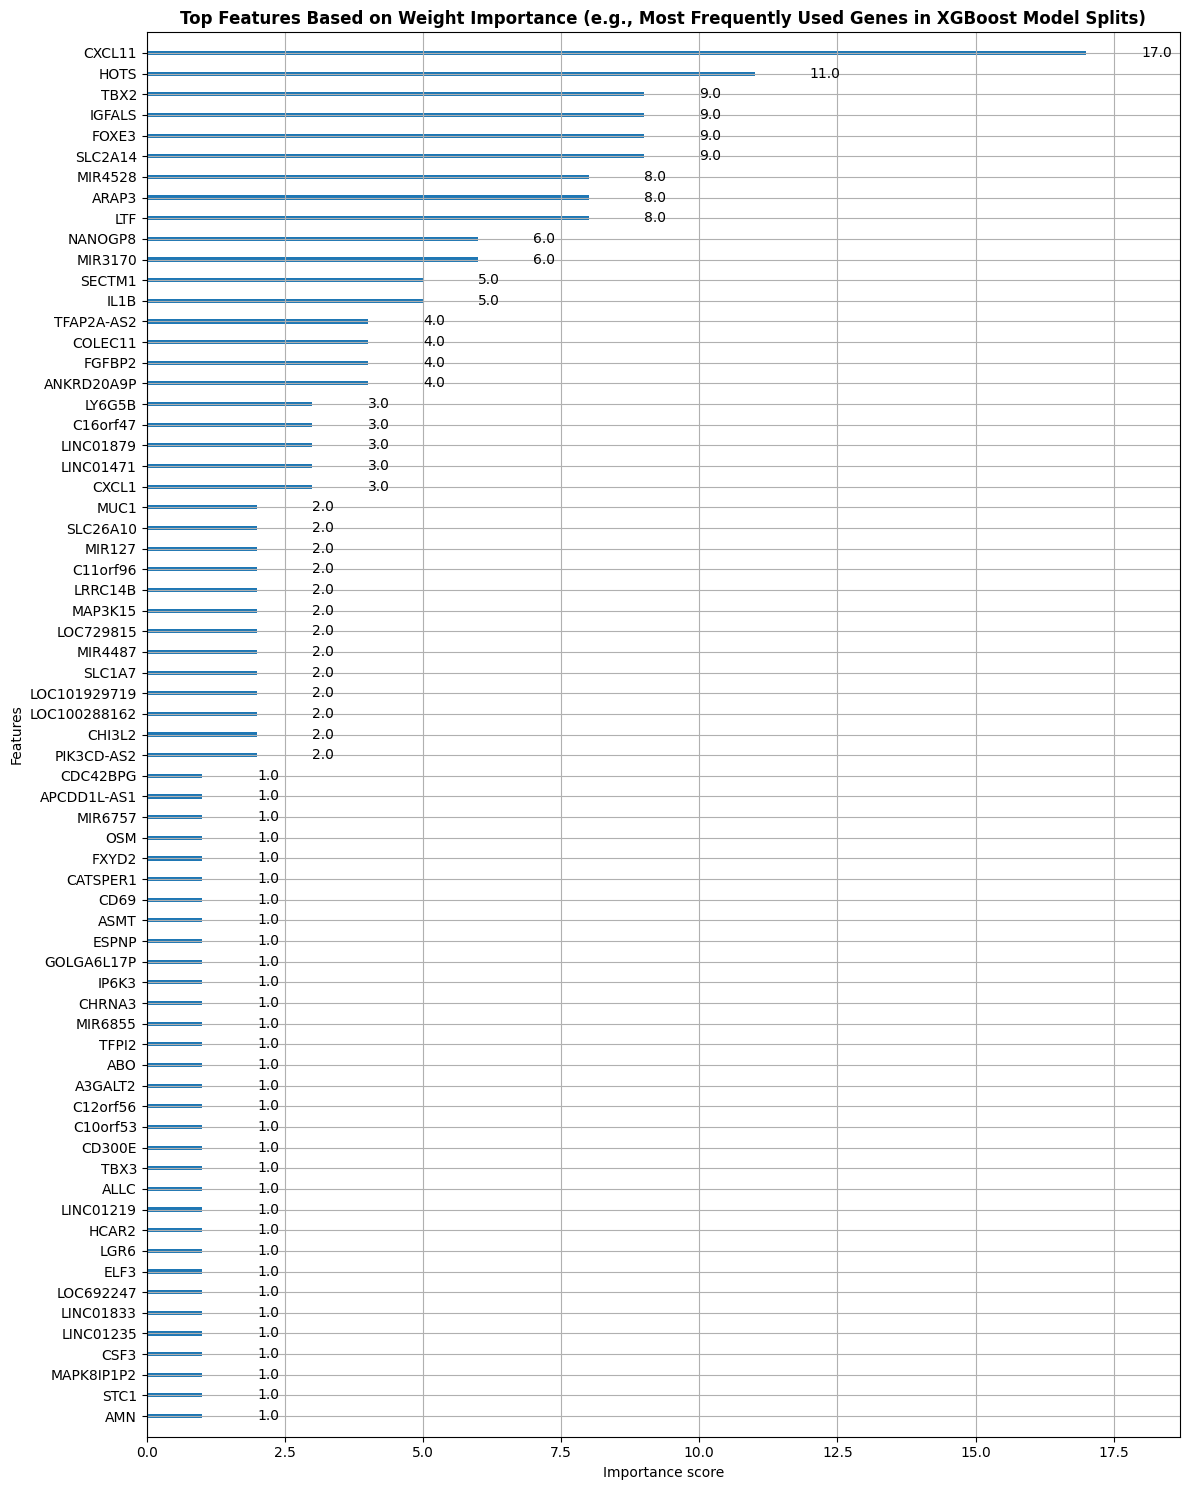

In [233]:
fig, ax = plt.subplots(figsize=(12, 15))  # Width x Height

# Visualize the feature importances of the trained XGBoost model
plot_importance(
    model,  # The trained XGBoost model whose feature importance we want to plot
    importance_type='weight',  # This calculates importance based on the number of times a feature is used in tree splits
    ax=ax  
)

# Adjust the font size of y-axis labels
ax.set_title("Top Features Based on Weight Importance (e.g., Most Frequently Used Genes in XGBoost Model Splits)", fontsize=12, fontweight="bold")
plt.yticks(fontsize=10) 
plt.tight_layout()
plt.show()

In [235]:
# Evaluate the accuracy of the trained model on the validation set
# This returns the mean accuracy on the given test data and labels
model.score(X_val, y_val)

0.8888888888888888

In [236]:
# Predict the class labels using the trained model
predicted_classes = model.predict(X_val)

# Print a detailed classification report including precision, recall, f1-score, and support for each class
print(classification_report(y_val, predicted_classes))

              precision    recall  f1-score   support

       False       0.50      0.50      0.50         4
        True       0.94      0.94      0.94        32

    accuracy                           0.89        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.89      0.89      0.89        36



In [241]:
# Extract the feature importance scores from the trained XGBoost model
# These scores represent how important each feature (gene) was in making predictions
importances = model.feature_importances_

# Get the indices that would sort the importances in descending order
# This identify the most important features first
indices = np.argsort(importances)[::-1]

# Select the top 100 most important feature indices
top_100_indices = indices[:100]

# Retrieve the names of the top 100 features using the indices
top_100_feature_names = X_train.columns[top_100_indices]

# Extract the importance scores of the top 100 features
top_100_importances = importances[top_100_indices]

# Create a pandas DataFrame for a cleaner display of the feature names and their corresponding importance scores
top_100_xg_boost = pd.DataFrame({
    'Feature': top_100_feature_names,
    'Importance': top_100_importances
})


In [242]:
top_100_xg_boost

,Feature,Importance
0,CXCL1,0.062540
1,NANOGP8,0.059928
2,APCDD1L-AS1,0.059692
3,MAP3K15,0.045430
4,ELF3,0.045316
...,...,...
95,GPR84,0.000000
96,SLAMF7,0.000000
97,ZNF645,0.000000
98,SPATA31A5,0.000000


In [243]:
top_100_xg_boost.set_index('Feature', inplace=True) ## set the name of the genes as index

In [244]:
top_100_xg_boost

,Importance
Feature,
CXCL1,0.062540
NANOGP8,0.059928
APCDD1L-AS1,0.059692
MAP3K15,0.045430
ELF3,0.045316
...,...
GPR84,0.000000
SLAMF7,0.000000
ZNF645,0.000000


In [249]:
# Find the common genes between the top DESeq2 genes (from ALS vs Control comparison)
# and the top 100 features identified by XGBoost
overall_common_relevant_genes = sorted_res_als_vs_control.index.intersection(top_100_xg_boost.index)

# Print the number of common genes and list them
print("Number of common genes between studies:", len(overall_common_relevant_genes), "\n", overall_common_relevant_genes)

Number of common genes between studies: 100 
 Index(['AMN', 'IL1B', 'CXCL1', 'STC1', 'PIK3CD-AS2', 'SECTM1', 'MAPK8IP1P2',
       'CSF3', 'SPATA31A5', 'SPATA31A7', 'CXCL11', 'CHI3L2', 'ANKRD20A9P',
       'LGALS17A', 'ZNF645', 'LOC100288162', 'HBD', 'IL6', 'WTAPP1', 'RPL29P2',
       'SPTA1', 'LTF', 'LINC01235', 'NXF2', 'NXF2B', 'CALCB', 'SIX3',
       'LINC01833', 'EXOC3L4', 'TH', 'CARMN', 'FGFBP2', 'MIR4673', 'LOC692247',
       'SELE', 'GPX2', 'GZMA', 'MIR181B1', 'ELF3', 'LGR6', 'MROH5', 'DGKK',
       'HCAR2', 'SLAMF7', 'SLC2A14', 'LINC01219', 'HOTS', 'LOC101929719',
       'SLC1A7', 'ALLC', 'TBX3', 'MIR4487', 'CD300E', 'LINC01471', 'COLEC11',
       'C10orf53', 'C12orf56', 'TFAP2A-AS2', 'A3GALT2', 'ABO', 'TFPI2',
       'MIR6855', 'CHRNA3', 'LOC729815', 'LINC01879', 'IP6K3', 'ARAP3',
       'GPR84', 'LOC339685', 'ANKRD20A19P', 'FOXE3', 'IGFALS', 'GOLGA6L17P',
       'ESPNP', 'ASMT', 'CD69', 'CATSPER1', 'MIR3170', 'MIR4528', 'MAP3K15',
       'FXYD2', 'C16orf47', 'LRRC14B', 'C11orf

  0%|          | 0/5 [00:00<?, ?it/s]

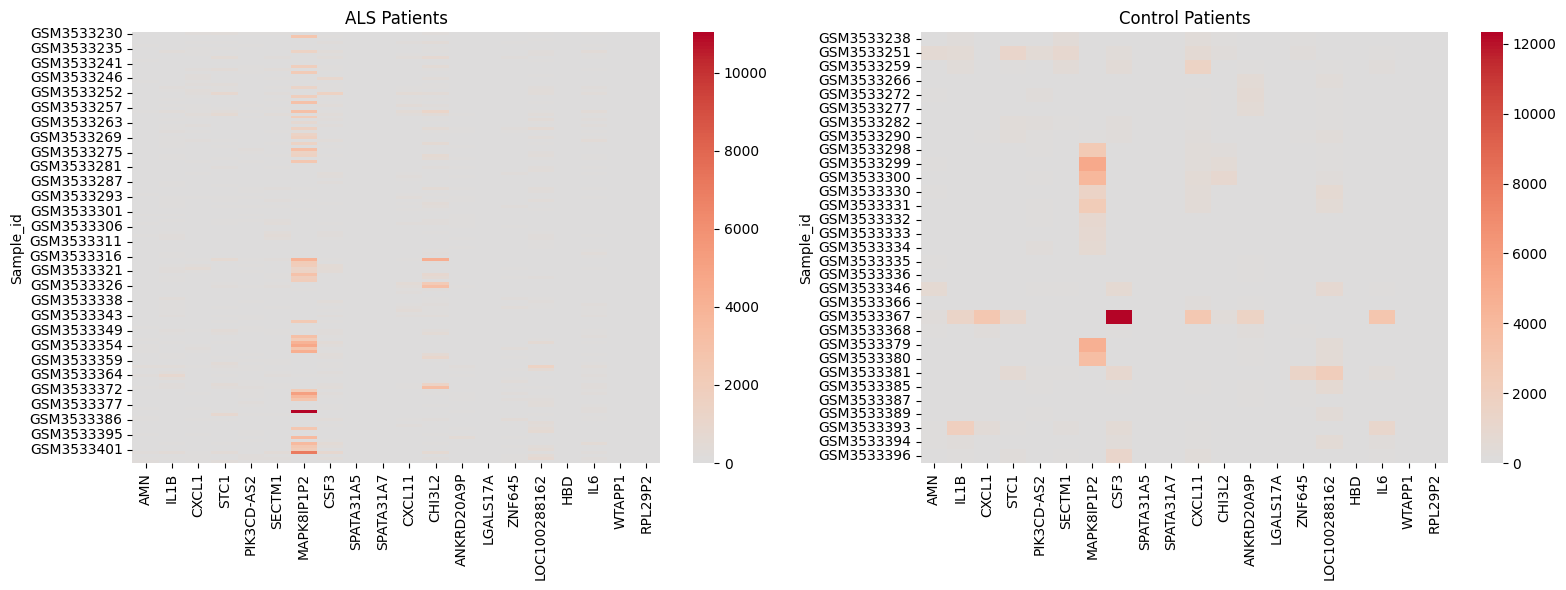

 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

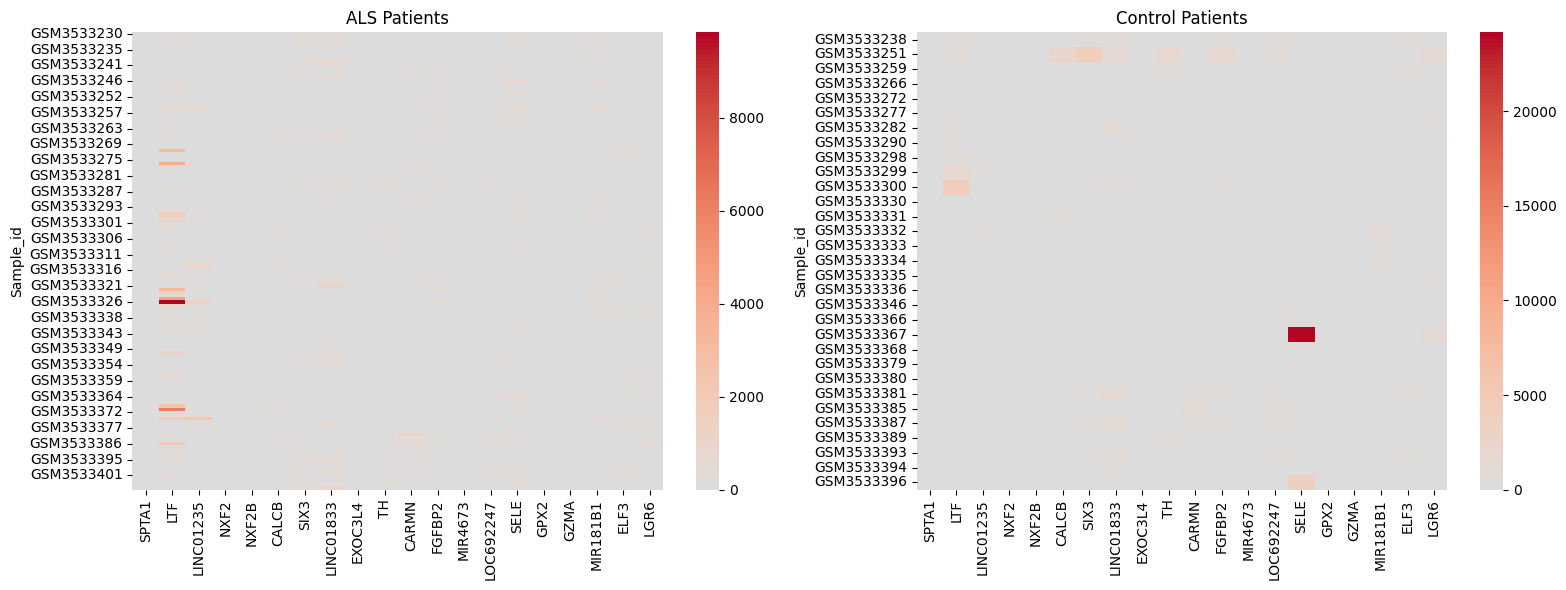

 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

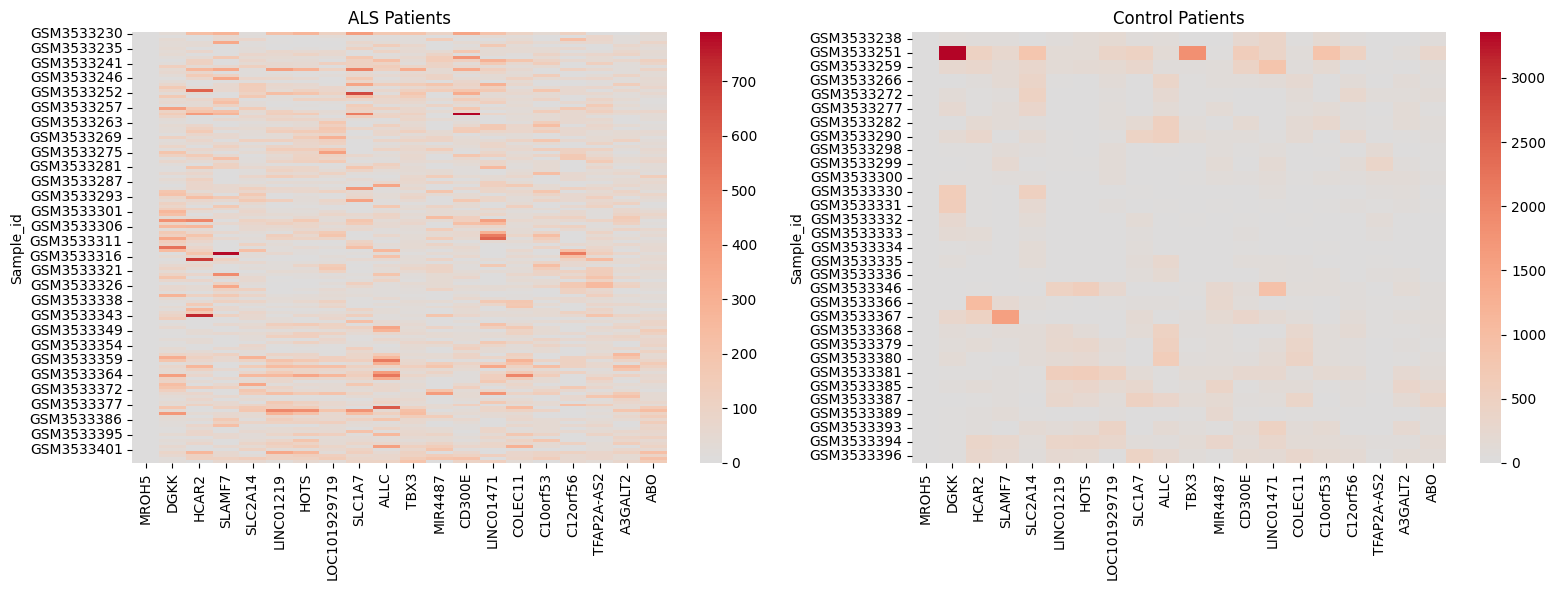

 60%|██████    | 3/5 [00:07<00:04,  2.31s/it]

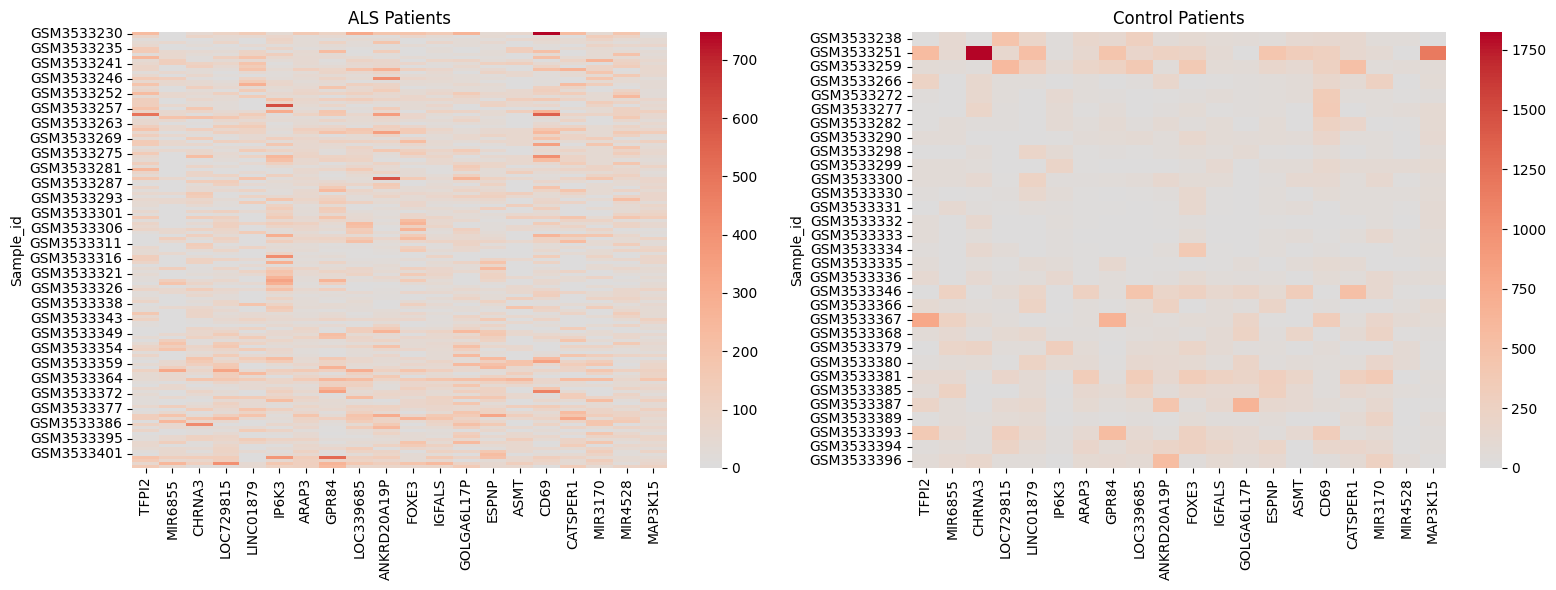

 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

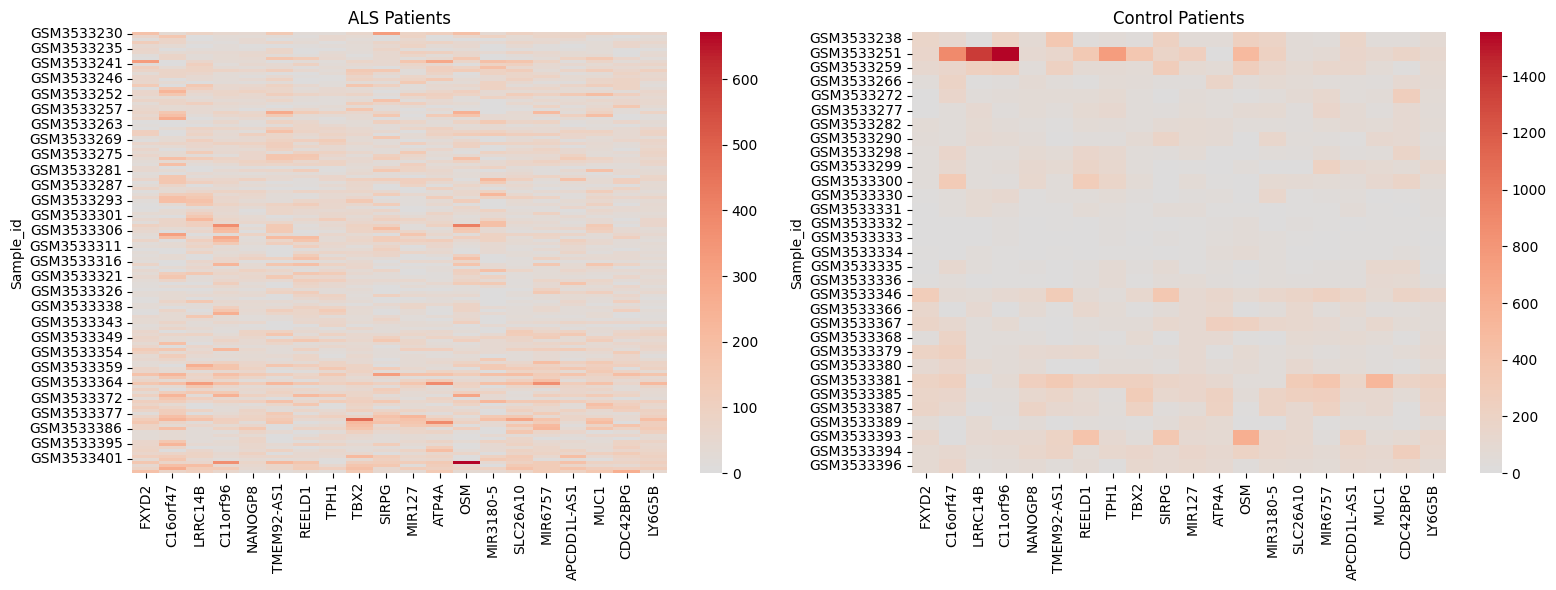

100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


In [250]:
# Loop through the common relevant genes in chunks of 20 genes at a time
# Efficiently handle large sets of genes and visualize them step-by-step
for i in tqdm(range(0, len(overall_common_relevant_genes), 20)) :
    # Create a subset of 20 genes from the overall common relevant genes
    subset_genes = overall_common_relevant_genes[i:i+20]
    
    # Visualize the comparison of these 20 genes between ALS and Control groups using the heatmap_comparison function
    # Assuming heatmap_comparison will generate a heatmap for each subset of genes
    heatmap_comparison(subset_genes, data_instance.get_data_als(), data_instance.get_data_control())